# Варіант 2

# Загрузка і очищення даних

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("data/adult.data", header=None) # Загрузка даних
column_names = ['age', 'workclass', 'fnlwgt', 'education', 
                'education-num', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'capital-gain', 
                'capital-loss', 'hours-per-week', 'native-country', 'result'] # імена всіх колонок
string_column_names = ['workclass', 'education', 'marital-status', 'occupation', 
                'relationship', 'race', 'sex', 'native-country', 'result'] # імена всіх колонок рядкового типу
def diff(li1, li2): 
    return (list(set(li1) - set(li2)))
numeric_column_names = diff(column_names, string_column_names) # імена всі колонок числового типу
df.columns = column_names
print(len(df))

32561


In [2]:
df.head() # перевіримо чи дані підгрузились

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  result  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

In [3]:
# Викинемо рядки, які містять пропущені дані
for name in df.columns: 
    if (any(df[name] == " ?")):
        df = df[df[name] != " ?"]

/home/username/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
# Перевіримо, скільки рядків було викинуто
print(len(df))

30162


# Попередня обробка даних

In [5]:
# Перетворимо категоріальні колонки у числові
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [6]:
# Перевіримо результат
fit_df = MultiColumnLabelEncoder(columns = string_column_names).fit_transform(df)
fit_df.head()

age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          5   77516          9             13               4   
1   50          4   83311          9             13               2   
2   38          2  215646         11              9               0   
3   53          2  234721          1              7               2   
4   28          2  338409          9             13               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     4    1          2174             0   
1           3             0     4    1             0             0   
2           5             1     4    1             0             0   
3           5             0     2    1             0             0   
4           9             5     2    0             0             0   

   hours-per-week  native-country  result  
0              40              38       0  
1              13              38       0  
2              40              38       0  
3              40              38       0  
4              40               4       0

In [7]:
# Виберемо вхідні параметри і вихідний параметр
X = fit_df.loc[:, df.columns != 'result']
y = fit_df['result']

# Допоміжні функції

In [8]:
# Функція для виведення точності моделі
def estimate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mislabeled_num = (y_test != y_pred).sum()
    precision = 1.0 - (mislabeled_num/X_test.shape[0])
    error = np.mean(y_pred != y_test)
    print("Number of mislabeled points out of a total %d points: %d with precision: %f" % 
          (X_test.shape[0], mislabeled_num, precision))
    return precision, error

In [9]:
# Функція для аналізу ROC-кривої
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
def roc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Model (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
# Генерація всіх можливих підмножин із списку
def subsets(s):
    """
    :type s: list[]
    """
    sets = []
    for i in range(2**len(s)):
        subset = []
        for j in range(len(s)):
            if i & (1 << j) > 0:
                subset.append(s[j])
        sets.append(subset)
    return sets

# Вибираємо лише числові колонки

In [33]:
X = fit_df[numeric_column_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # split data

# Машина опорних векторів

In [35]:
# Вибираємо лише числові колонки
X = fit_df[numeric_column_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # split data
# Нормуємо вхідні дані
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

/home/username/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


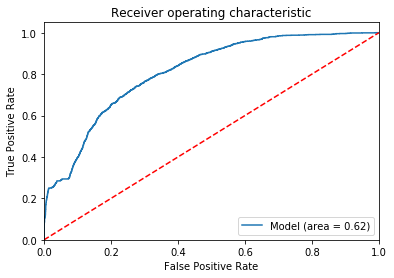

Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149


(0.791148682247638, 0.20885131775236201)

In [36]:
# Побудова 1 моделі
from sklearn import svm
model = svm.SVC(kernel='linear', cache_size=7000, probability=True) # Linear Kernel
model.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [37]:
# Побудова всіх можливих моделей на основі числових колонок
cols = subsets(numeric_column_names[:-1])[1:] # формуємо всі підмножини числових колонок, окрім порожньої

In [ ]:
# Цей код може працювати повільно, оскільки він створює багато моделей, кількість яких рівна 2^6 - 1, 
# адже ми перебираємо всі підмножини колонок, окрім порожної
precision = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
for col in cols:
    X_train_i, X_test_i = X_train[col], X_test[col]
    model = svm.SVC(kernel='linear', cache_size=7000, probability=True) # Linear Kernel
    model.fit(X_train_i, y_train)
    print(col)
    prec, _ = estimate(model, X_test_i, y_test)
    precision.append(prec) # Зберігаємо точність моделей, щоб потім вибрати найкращу

In [ ]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model uses the following columns %s with precision %f" % (cols[index], precision[index]))

In [ ]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model uses the following columns %s with precision %f" % (cols[index], precision[index]))

In [ ]:
 # Побудуємо найкращу модель ще раз
col = cols[index]
X_train_i, X_test_i = X_train[col], X_test[col]
model = svm.SVC(kernel='linear', cache_size=7000, probability=True) # Linear Kernel
model.fit(X_train_i, y_train)
roc(model, X_test_i, y_test)
estimate(model, X_test_i, y_test)

# Дерево рішень

In [11]:
# Вибір даних
# Виберемо вхідні параметри і вихідний параметр
X = fit_df.loc[:, df.columns != 'result']
y = fit_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data

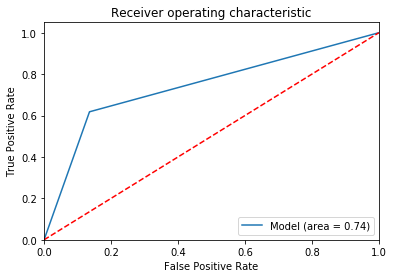

Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083


(0.8030830432620587, 0.19691695673794132)

In [12]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [13]:
# Побудова всіх можливих моделей на основі числових колонок
cols = subsets(column_names[:-1])[1:] # формуємо всі підмножини числових колонок, окрім порожньої

In [14]:
# Цей код може працювати повільно, оскільки він створює багато моделей, кількість яких рівна 2^14 - 1, 
# адже ми перебираємо всі підмножини колонок, окрім порожної
precision = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
for col in cols:
    X_train_i, X_test_i = X_train[col], X_test[col]
    model = tree.DecisionTreeClassifier()
    model = model.fit(X_train_i, y_train)
    print(col)
    prec, _ = estimate(model, X_test_i, y_test)
    precision.append(prec) # Зберігаємо точність моделей, щоб потім вибрати найкращу

['age']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['age', 'workclass']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['fnlwgt']
Number of mislabeled points out of a total 6033 points: 1967 with precision: 0.673960
['age', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1919 with precision: 0.681916
['workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1997 with precision: 0.668987
['age', 'workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1928 with precision: 0.680424
['education']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'education']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'education']
Number of mislabeled points out of a 

['fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1897 with precision: 0.685563
['age', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1775 with precision: 0.705785
['workclass', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1923 with precision: 0.681253
['age', 'workclass', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1756 with precision: 0.708934
['education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['workclass', 'education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'workclass', 'education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506
['fnlwgt', 'educatio

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['relationship']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'relationship']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['workclass', 'relationship']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'relationship']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['fnlwgt', 'relationship']
Number of mislabeled points out of a total 6033 points: 1654 with precision: 0.725841
['age', 'fnlwgt', 'relationship']
Number of mislabeled points out of a total 6033 points: 1629 with precision: 0.729985
['workclass', 'fnlwgt', 'relationship']
Number of mislabeled points out of a total 6033 points: 1668 with precision: 0.723521
['age', 'w

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['workclass', 'occupation', 'relationship']
Number of mislabeled points out

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['education', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1250 

['fnlwgt', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['age', 'fnlwgt', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['education', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['age', 'education', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['workclass', 'education', 'education-num', 'marital-status', 'race']
Number of mislabeled points out of a 

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['education-num', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'education-num', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['workclass', 'education-num', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
['age', 'workclass', 'education-num', 'marital-status', 'o

['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1657 with precision: 0.725344
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1650 with precision: 0.726504
['education', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'education', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'education', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education', 'marital-status', 'relationship', 'race']
Number of misla

['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['marital-status', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['age', 'marital-status', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['workc

['age', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['workclass', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['age', 'workclass', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1755 with precision: 0.709100
['age', 'fnlwgt', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1660 with precision: 0.724847
['workclass', 'fnlwgt', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1754 with precision: 0.709266
['age', 'workclass', 'fnlwgt', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1672 with precision: 0.722858
['education', 'education-num', 'sex']
Number of mislabeled points out of a total 6033 points: 1365 with

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1638 with precision: 0.728493
['education-num', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'education-num', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'education-num', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'education-num', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['fnlwgt', 'education-num', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1759 with precision: 0.708437
['age', 'fnlwgt', 'education-num', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1624 with precision: 0.730814
['workclass', 'fnlwgt', 'educati

['age', 'workclass', 'fnlwgt', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1642 with precision: 0.727830
['education', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1119 with precision: 0.814520
['age', 'education', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['workclass', 'education', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['age', 'workclass', 'education', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442
['fnlwgt', 'education', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['age', 'fnlwgt', 'education', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['workclass', 'fnlwgt', 'education', 'relationship', 's

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['workclass', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['age', 'workclass', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['fnlwgt', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabele

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['education-num', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['age', 'education-num', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['workclass', 'education-num', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex']
Number of mislabeled points out of

['education', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['age', 'education', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1455 with precision: 0.758826
['workclass', 'fnlwgt', 'education', 'marital-statu

Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291
['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1624 with precision: 0.730814
['age'

['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1401 with precision: 0.767777
['education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.

['fnlwgt', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1638 with precision: 0.728493
['age', 'fnlwgt', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1611 with precision: 0.732969
['workclass', 'fnlwgt', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1692 with precision: 0.719543
['age', 'workclass', 'fnlwgt', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1643 with precision: 0.727665
['education', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884
['age', 'education', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['workclass', 'education', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'workclass', 'education', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['fn

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['age', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['workclass', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['age', 'workclass', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['fnlwgt', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1601 with precision: 0.734626
['age', 'f

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1037 with precision: 0.828112
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 603

['workclass', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1247 with precisio

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 955 with precision: 0.841704
['age', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 

['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['age', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['workclass', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['age', 'workclass', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['fnlwgt', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898
['workclass

['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1674 with precision: 0.722526
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346
['education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['workclass', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 point

['education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 p

['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabele

['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1539 with precision: 0.744903
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['workclass', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain']
Number of mislabeled points out of 

['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['age', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['workclass', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain']
N

['fnlwgt', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 999 with precision: 0.834411
['workclass', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 951 with pr

['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0.827781
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 

['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['age', 'education-num', 'marital-status', 'occupation', 'rela

Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697
['workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808719
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['age'

Number of mislabeled points out of a total 6033 points: 1529 with precision: 0.746561
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1555 with precision: 0.742251
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1449 with precision: 0.759821
['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['workclass', 'education', 'education-num', 'occupation', 'race', 

['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of m

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 972 with precision: 0.838886
['age', 'workclass', 'education', 'education-

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 974 with precision: 0.838555
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', '

['age', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1692 with precision: 0.719543
['workclass', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1764 with precision: 0.707608
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1662 with precision: 0.724515
['education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['age', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.78136

['age', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1687 with precision: 0.720371
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1706 with precision: 0.717222
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1659 with precision: 0.725012
['education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 po

['age', 'fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1556 with precision: 0.742085
['workclass', 'fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1559 with precision: 0.741588
['education', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'education', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['workclass', 'education', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'workclass', 'education', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['fnl

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['workclass', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['age', 'w

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1049 with precision: 0.826123
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Nu

['age', 'fnlwgt', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1604 with precision: 0.734129
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1592 with precision: 0.736118
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['education', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'education', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['workclass', 'education', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'education', 'marital-status', 'race', 'capital-loss']
Number of mislabeled 

['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1786 with precision: 0.703962
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1710 with precision: 0.716559
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1763 with precision: 0.707774
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1640 with precision: 0.728162
['marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697
['workc

['age', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['workclass', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['age', 'workclass', 'fnlwgt', 'education-num'

['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['education', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'education', 'occupation', 'relat

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'education', 'educa

['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['workclass', 'education-num', 'marital-status', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'workclass', 'education-num', 'marital-statu

['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'workclass'

['education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.7689

['age', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442
['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['age'

['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1492 with precision: 0.752694
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precisi

['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of 

['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469

['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1401 with precision: 0.767777
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['

['fnlwgt', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 883 with precision: 0.853638
['age', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['workclass', 'education', 'marital-status', 'capital-gain', 'capit

Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1509 with precision: 0.749876
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0.749378
['age', 'workcla

['fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['workclass', 'educ

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'occupation', 'relationship', 'c

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['workclass', 'e

['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['age', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['workclass', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['ag

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1171 with precision: 0.805901
['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1482 w

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['age', 'relationship

['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 895 with precision: 0.851649
['age', 'education-num', 'marital-status', 'rel

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 poi

['age', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['age', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total

['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 973 with precision: 0.838720
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['age', 'workclass', 'fnlwgt', 'education', 'educ

Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735
['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 868 w

['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 973 with precision: 0.838720
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['age', 'workclass', 'fnlwgt', 'education', 'education-num'

['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1055 with precision: 0.825128
['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number 

Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'education', 'education-num', 'marital-status', 'occupation'

['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['education', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 890 w

Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1464 with precision: 0.757335
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['age'

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['age', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['workclass', 'relationship', 'race

['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['age', 'edu

['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884
['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 932 with preci

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['hours-per-week']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052
['workclass', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'workclass', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550
['fnlwgt', 'hours-per-week']
Number of mislabeled points out of

['age', 'education', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['workclass', 'education', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['age', 'workclass', 'education', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1472 with precision: 0

['age', 'education-num', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['workclass', 'education-num', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1470 with precision: 0.756340
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1458 with precis

['age', 'fnlwgt', 'marital-status', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1657 with precision: 0.725344
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1686 with precision: 0.720537
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1616 with precision: 0.732140
['education', 'marital-status', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['age', 'education', 'marital-status', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['workclass', 'education', 'marital-status', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735
['age', 'workclass', 'education', 'ma

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['education', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['age', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points o

['workclass', 'fnlwgt', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1942 with precision: 0.678104
['age', 'workclass', 'fnlwgt', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1801 with precision: 0.701475
['education', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'education', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['workclass', 'education', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['age', 'workclass', 'education', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['fnlwgt', 'education', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1810 with precision: 0.699983
['age', 'fnlwgt', 'education', 'race', 'h

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805
['age', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['workclass', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['age', 'workclass', 'occupation', 'race', 'ho

['age', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled poi

['fnlwgt', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1660 with precision: 0.724847
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1641 with precision: 0.727996
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1652 with precision: 0.726173
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1634 with precision: 0.729156
['education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['age', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['wor

['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mis

['workclass', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['age', 'workclass', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1526 with precision: 0.747058
['fnlwgt', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1928 with precision: 0.680424
['age', 'fnlwgt', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1801 with precision: 0.701475
['workclass', 'fnlwgt', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1927 with precision: 0.680590
['age', 'workclass', 'fnlwgt', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1810 with precision: 0.699983
['education', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'education', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6

Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['age', 'workclass', 'fnlwgt', 

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['age', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['age', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1445 with precision: 0.760484
['workclass', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['age', 'workclass', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['fnlwgt', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1684 with precision: 0.720869
['age', 'fnlwgt', 'marital-statu

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['education-num', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['age', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['age', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['workclass', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1499 with 

['workclass', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 

['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1551 with precision: 0.742914
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067
['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1353 

['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1444 with precision: 0.760650
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382
['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a to

['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1184 with precisi

['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661
['age', 'fnlwgt', 'educat

['age', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['workclass', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['age', 'workclass', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-

['fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1525 with precision: 0.747224
['education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['age', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 

['age', 'workclass', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['fnlwgt', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1445 with precision: 0.760484
['education', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['age', 'education', 'relationship', 'capital-gain', 'hours-per-we

['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['education', 'education-num', 'marital-

['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['education', 'marital-status', 'occupation', 'relation

['fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['age', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass

['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1617 with precision: 0.731974
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346
['education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['age', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['workclass', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['age', 'work

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['educatio

['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890
['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabel

['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['workclass', 'education-num', 'occupation', 'relations

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'h

['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabele

['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923
['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex'

['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 967 with precision: 0.839715
['age', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0

['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['age', 'edu

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748
['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['fnlwgt', 'marital-status', 'occupati

['fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1547 with precision: 0.743577
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1484 with precision: 0.754020
['education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['workclass

['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['age', 'occupation', 'race', 'sex

['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['workclass', 'fnlwgt', 'edu

['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'education', 'education

['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442
['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-ga

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislab

['age', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1616 with precision: 0.732140
['workclass', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1697 with precision: 0.718714
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1629 with precision: 0.729985
['marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['workclass', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'marital-status', '

['age', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1449 with precision: 0.759821
['workclass', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661
['fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1711 with precision: 0.716393
['age', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1695 with precision: 0.71904

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['workclass', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'workclass', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['fnlwgt', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1599 with precision: 0.734958
['age', 'fnlwgt', 'relationship', 'capital-loss', 'h

['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1090 with precision: 0.819327
['age', 'education', 'education-num', 'marital-

['age', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 

['workclass', 'fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1706 with precision: 0.717222
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1628 with precision: 0.730151
['education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['fnlwgt', 'education-num', 'race', 'ca

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1445 with precision: 0.760484
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1353 with precision: 0.775733
['age', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1468 with precision: 0.756672
['workclass', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1486 with p

Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890
['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 60

['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1444 with precision: 0.760650
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1431 with precision: 0.762805
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['marital-status', 'relat

['education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hour

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislab

['age', 'workclass', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1613 with precision: 0.732637
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['education', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'ed

['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1626 with precision: 0.730482
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1585 with precision: 0.737278
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1628 with precision: 0.730151
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1576 with precision: 0.738770
['education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabele

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['age', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'workclass', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['fnlwgt', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1598 with precision: 0.735123
['age', 'f

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'education-num', 'marital-st

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1373 with precision: 0.772418
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 603

['fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1805 with precision: 0.700812
['age', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1751 with precision: 0.709763
['workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1797 with precision: 0.702138
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1742 with precision: 0.711255
['education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'education', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['workclass', 'education', 'race', 'sex', 'capital-loss', 'hours-per-we

['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'education', 'education-num', 'marital-statu

['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['education', 'marital-status', 'occupation', 'race', 'sex',

['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['age', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hour

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1423 with precision: 0.764131
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Num

['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 wi

['education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['workclass', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['workcla

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852
['age', 'workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1521 with 

['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age',

Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hou

['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 956 with precision: 0.841538
['age', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['workclass', 'education', 'occupation', 'relationship', 'capit

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mi

['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['marital-status', 'race'

['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hour

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislab

['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1114 with precision: 0.815349
['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0

['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 972 with precision: 0.838886
['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748
['age', 'workc

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 974 with precision: 0.838555
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capit

['age', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735
['workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'c

['age', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of

['education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1186 with precisi

['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a

['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 955 with precision: 0.841704
['age', 'education', 'occupation', 're

['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-lo

['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1022 with precision: 0.830598
['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['workclass', 'education', 'education-num', 'race', 

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['age', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276
['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-l

['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1141 with precision: 0.810874
['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of

['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1210 

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'rel

Number of mislabeled points out of a total 6033 points: 1160 with precision: 0.807724
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1149 with precision: 0.809547
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['workclass', 'fnlwgt', 'marital-status', 'occupation',

['age', 'workclass', 'education', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['fnlwgt', 'education', 'native-country']
Number of mislabeled points out of a total 6033 points: 1821 with precision: 0.698160
['age', 'fnlwgt', 'education', 'native-country']
Number of mislabeled points out of a total 6033 points: 1762 with precision: 0.707940
['workclass', 'fnlwgt', 'education', 'native-country']
Number of mislabeled points out of a total 6033 points: 1839 with precision: 0.695177
['age', 'workclass', 'fnlwgt', 'education', 'native-country']
Number of mislabeled points out of a total 6033 points: 1735 with precision: 0.712415
['education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['age', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['workclass', 'education-num', 'native-country']
Number of 

['age', 'fnlwgt', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1785 with precision: 0.704127
['workclass', 'fnlwgt', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1938 with precision: 0.678767
['age', 'workclass', 'fnlwgt', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1761 with precision: 0.708105
['education', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['age', 'education', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['workclass', 'education', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['age', 'workclass', 'education', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699
['fnl

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['age', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['w

['age', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['workclass', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1529 with precision: 0.746561
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506
['education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points:

['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1756 with precision: 0.708934
['education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['age', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['workclass', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'workclass', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['fnlwgt', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1848 with precision: 0.693685
['age', 'fnlwgt', 'education', 'education-num', 'race', 'native-country']
N

['fnlwgt', 'education', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1835 with precision: 0.695840
['age', 'fnlwgt', 'education', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1754 with precision: 0.709266
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1810 with precision: 0.699983
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1722 with precision: 0.714570
['education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683
['workclass', 'education-num', 'occupation', 'race', 'native-coun

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['age', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.76479

['age', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mi

['marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['age', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 point

['workclass', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'workclass', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1762 with precision: 0.707940
['age', 'fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1695 with precision: 0.719045
['workclass', 'fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1772 with precision: 0.706282
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1644 with precision: 0.727499
['education', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1

['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1653 with precision: 0.726007
['education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['workclass', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'workclass', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1449 with precision: 0.759821
['fnlwgt', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1744 with precision: 0.710923
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points o

['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-

['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1487 with precision: 0.753522
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1450 with precision: 0.759655
['education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a 

['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291
['marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['age', 'marital-status', 'occupation', 'relationship', 'sex', 'native-c

['age', 'workclass', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1746 with precision: 0.710592
['age', 'fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1660 with precision: 0.724847
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1737 with precision: 0.712084
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1663 with precision: 0.724349
['education-num', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'education-num', 'race', 'sex', 'native-country']
Number of mislabeled points out of a tot

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1456 with precision: 0.758661
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['age', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['age', 'workclass', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['fnlwgt', 'occupation', 'race', 's

['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 

['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1627 with precision: 0.730317
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1652 with precision: 0.726173
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1624 with precision: 0.730814
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1620 with precision: 0.731477
['education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 p

['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291
['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382
['age', 'education', 'education-num', 'occupation', 'relationship', 'rac

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['age', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['workclass', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'workclass', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['fnlwgt', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1641 with precision: 0.727996
['age', 'fnlwgt', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1608 with

['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a t

['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a tot

Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1001 with precision: 0.834079
['workclass', 'education', 'education-num'

Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['workclass', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1315 with precision: 0.782032
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', '

['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['wo

Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['workclass', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['age', 'workclass', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1443 with precision: 0.760816
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Numbe

['age', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1593 with precision: 0.735952
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1496 with precision: 0.752030
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713
['workclass', 'relationship', 'race', 'capital-gain', 'nativ

['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 960 with precision: 0.840875
['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['workclass', 'education-num', 'mari

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a tota

['fnlwgt', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['age', 'fnlwgt', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1622 with precision: 0.731145
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1636 with precision: 0.728825
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1639 with precision: 0.728328
['education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['workclass', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 poi

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 959 with precision: 0.841041
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1055 with precision: 0.825128
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 931 with precision: 0.845682
['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', '

['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 992 with precision: 0.835571
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-cou

['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled poin

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 978 with precision: 0.837892
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 9

['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313
['marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points

Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1532 with precision: 0.746063
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'educat

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a tota

['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1423 with precision: 0.764131
['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 963 with precision: 0.840378
['age', 'education', 'marital-status', 'relationship', 'ra

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 974 with precision: 0.838555
['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['fnlwgt', 'education

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', '

['age', 'workclass', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['fnlwgt', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1416 with precision: 0.765291
['age', 'fnlwgt', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1423 with precision: 0.764131
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1079 with prec

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1652 with precision: 0.726173
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1739 with precision: 0.711752
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1669 with precision: 0.723355
['marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['age', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852
['workclass', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total

['age', 'fnlwgt', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['workclass', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.82181

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1454 with precision: 0.758992
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['age', 'occupation', 'relati

['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision:

['fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1772 with precision: 0.706282
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1606 with precision: 0.733797
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1756 with precision: 0.708934
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1636 with precision: 0.728825
['marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['age', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with pre

['fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1785 with precision: 0.704127
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1649 with precision: 0.726670
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1696 with precision: 0.718879
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1679 with precision: 0.721697
['education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points:

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out

['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1092 with precision: 0.818996
['age', 'education-num', 'marital-st

['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['age

['age', 'fnlwgt', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1760 with precision: 0.708271
['workclass', 'fnlwgt', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1799 with precision: 0.701807
['age', 'workclass', 'fnlwgt', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1754 with precision: 0.709266
['education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['workclass', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points 

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442
['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss',

['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number 

Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1450 with precision: 0.759655
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['workclass', 'fnlwgt', 'occupation', 'relationship', 'se

['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1

['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1662 with precision: 0.724515
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1683 with precision: 0.721034
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['age', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points

['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1712 with precision: 0.716227
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1647 with precision: 0.727001
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1536 with precision: 0.745400
['education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mis

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-countr

['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1576 with precision: 0.738770
['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['fnlwgt', 'education', 'mar

['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['workclass', 'fnl

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship'

['fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 883 with precision: 0.853638
['age', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'n

['age', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1206 with precision: 0.800099
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1514 with precision: 0.749047
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['workclass', 'fnlwgt', 'edu

['age', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['workclass', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a tota

['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.80

['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out o

['age', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1526 with precision: 0.747058
['workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1542 with precision: 0.744406
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
[

['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1155 with precision: 0.808553
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067


['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['age', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 980 with precision: 0.837560
['workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 916 with precision: 0.848168
['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['fnlwgt', 'marital-status', 'occupa

['age', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1049 with precision: 0.826123
['fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['age', 'fnlwgt', 'education', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'cap

['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mis

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of

['fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['age', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1523 with precision: 0.747555
['workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1503 with precision: 0.750870
['education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['workclass', 'educatio

['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'educ

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['fnlwgt', 'marital-status', 'occupation'

['education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'n

['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of m

['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country'

['fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1460 with precision: 0.757998
['education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 

['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 968 with precision: 0.839549
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 933 with precision: 0.845351
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757


['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1455 with precision: 0.758826
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1463 with precision: 0.757500
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number

['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'education', 'relationship', 'race', 'sex', 'capital-gain', 

['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 903 with precision: 0.850323
['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 986 with precision: 0.836566
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number o

['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 917 with precision: 0.848003
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss'

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216


['age', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1256 with precision: 0.791812
['workclass', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['age', 'workclass', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['fnlwgt', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1461 with precision: 0.757832
['age', 'fnlwgt', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 

['workclass', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'workclass', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['fnlwgt', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1567 with precision: 0.740262
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 

['fnlwgt', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1478 with precision: 0.755014
['age', 'fnlwgt', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036
['workclass', 'fnlwgt', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1412 with precision: 0.765954
['education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['age', 'education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a 

['age', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['workclass', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'workclass', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1526 with precision: 0.747058
['age', 'fnlwgt', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['workclass', 'fnlwgt', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1512 with precision: 0

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.80

['fnlwgt', 'education', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1809 with precision: 0.700149
['age', 'fnlwgt', 'education', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1682 with precision: 0.721200
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1795 with precision: 0.702470
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1678 with precision: 0.721863
['marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489
['age', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1

['age', 'workclass', 'education', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['fnlwgt', 'education', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1819 with precision: 0.698492
['age', 'fnlwgt', 'education', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1645 with precision: 0.727333
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1769 with precision: 0.706779
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1702 with precision: 0.717885
['education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of

['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1450 with precision: 0.759655
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points

['age', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['workclass', 'fnlwgt', 'education', 'marit

['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098
['education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workc

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1525 with precision: 0.747224
['age', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699
['workclass', 'sex', 'hours-per-week

['age', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['workclass', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['age', 'workclass', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number

['age', 'workclass', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1543 with precision: 0.744240
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1499 with precision: 0.751533
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1547 with precision: 0.743577
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['education', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
N

['fnlwgt', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1444 with precision: 0.760650
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['age', 'education', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-count

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['age', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['workclass', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['age', 'workclass', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mi

['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out

['workclass', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1710 with precision: 0.716559
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1616 with precision: 0.732140
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1712 with precision: 0.716227
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', '

['education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1726 with precision: 0.713907
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points o

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 

['age', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1672 with precision: 0.722858
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1631 with precision: 0.729654
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 

['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1347 with precision: 0.776728
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.76

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1471 with precision: 0.756174
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1387 with precision: 0.770098
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-wee

['age', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['workclass', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1459 with precision: 0.758163
['workclass', 'fnlwgt', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points

['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1558 with precision: 0.741754
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945
['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'hours-per-week',

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1022 with precision: 0.830598
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country'

['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1428 with precision: 0.763302
['education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['workclass', 'education', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['age', 'workclass', 'ed

['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['w

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1149 with precision: 0.809547
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'r

['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['age', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['age', 'workclass', 'education', 'marital-status', 'race', 'cap

['age', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1604 with precision: 0.734129
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1494 with precision: 0.752362
['workclass', 'fnlwgt', 'education-num', 'o

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-g

['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['a

['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poi

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'r

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['age', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['workclass', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945
['fnlwgt', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of 

['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1545 with precision: 0.743909
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1508 with precision: 0.750041
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['education-num', 'occupation', 'se

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number o

Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462
['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabe

['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a tota

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relat

['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1507 with precision: 0.750207
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['age', 'workclass', 'marital-status', 'rac

['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['workclass', 'fnlwgt', 'edu

Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'fnlwgt', '

['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabel

['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precisi

['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['education-num', 'marital-status', 'occupation', 'relations

['workclass', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1706 with precision: 0.717222
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1639 with precision: 0.728328
['education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Numbe

['age', 'fnlwgt', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1643 with precision: 0.727665
['workclass', 'fnlwgt', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1765 with precision: 0.707442
['age', 'workclass', 'fnlwgt', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1647 with precision: 0.727001
['education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['age', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489
['workclass', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a to

['age', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.

['fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1370 with precision: 0.772916
['marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age',

['age', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1459 with precision: 0.758163
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['workclass', 'education', 'occupation', 'relationsh

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
N

['workclass', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'workclass', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1735 with precision: 0.712415
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1647 with precision: 0.727001
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1661 with precision: 0.724681
['age', 'workclass', 'fnlwgt', '

['workclass', 'fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1779 with precision: 0.705122
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1632 with precision: 0.729488
['education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1482 with precision: 0.754351
['workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['age', 'workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-

['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a to

['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled 

['fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['age', 'education', '

['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss'

['age', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1557 with precision: 0.741919
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1654 with precision: 0.725841
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102
['education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week

['age', 'workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1690 with precision: 0.719874
['age', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1581 with precision: 0.737941
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1687 with precision: 0.720371
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1601 with precision: 0.734626
['education', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mis

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 60

Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1385 with precision: 0.770429
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-

['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1459 with precision: 0.758163
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1455 with precision: 0.758826
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'education', 'occup

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'h

['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1395 with precision: 0.768772
['fnlwgt', 'education',

['age', 'workclass', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1704 with precision: 0.717553
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1595 with precision: 0.735621
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1706 with precision: 0.717222
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1606 with precision: 0.733797
['education', 'occupation', 'race', 'sex', 'capital-loss', '

['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number 

['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['occupation', 'relationship', 'race', 'sex', 'c

['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-w

['workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'workclass', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', '

['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1488 with precision: 0.753357
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points:

['age', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.778551
['education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['age', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['workclass', 'education', 'relationship', 

['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['age', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-co

['fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', '

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.80043

['fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 934 with precision: 0.845185
['a

['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0.754517
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poin

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'r

['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-pe

['age', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713
['workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points:

['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['workclass', 'education', 'marital-status', 'occupation', 'relationshi

['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['age', 'education-num', 'sex', 'capital-

['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 933 with precision: 0.845351
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1369 with precision: 0.773081
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Numb

['fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['age', 'education

['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-

['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['age', '

['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1388 with precision: 0.769932
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out o

['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with 

['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0.827781
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808719
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'se

['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 988 with precision: 0.836234
['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number 

['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['education', 'education-num', 'mari

['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 972 with precision: 0.838886
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1155 with precision: 0.808553
['fnlwgt', 'education', 'education-num', 

Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capit

In [15]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The worse model: with k = 6 with precision 0.668987


In [16]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The best model: with k = 3186 with precision 0.857782


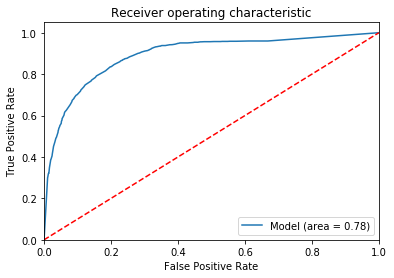

Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953


(0.8569534228410409, 0.14304657715895905)

In [18]:
 # Побудуємо найкращу модель ще раз
col = cols[index]
X_train_i, X_test_i = X_train[col], X_test[col]
model = tree.DecisionTreeClassifier()
model.fit(X_train_i, y_train)
roc(model, X_test_i, y_test)
estimate(model, X_test_i, y_test)

# AdaBoost

In [19]:
# Вибір даних
# Виберемо вхідні параметри і вихідний параметр
X = fit_df.loc[:, df.columns != 'result']
y = fit_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data

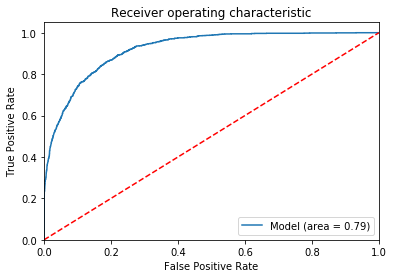

Number of mislabeled points out of a total 6033 points: 831 with precision: 0.862258


(0.8622575832918946, 0.13774241670810541)

In [20]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
model.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [21]:
# Застереження: код працює повільно
# Цей код може працювати повільно, оскільки він створює багато моделей, кількість яких рівна 2^14 - 1, 
# адже ми перебираємо всі підмножини колонок, окрім порожної
X = fit_df.loc[:, df.columns != 'result']
cols = subsets(column_names[:-1])[1:]

precision = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
for col in cols:
    X_train_i, X_test_i = X_train[col], X_test[col]
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
    model.fit(X_train_i, y_train)
    print(col)
    prec, _ = estimate(model, X_test_i, y_test)
    precision.append(prec)

['age']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['age', 'workclass']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['fnlwgt']
Number of mislabeled points out of a total 6033 points: 1510 with precision: 0.749710
['age', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1502 with precision: 0.751036
['workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['age', 'workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['education']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'education']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['workclass', 'education']
Number of mislabeled points out of a 

Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['age', 'workclass', 'occupation']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1475 with precision: 0.755511
['age', 'workclass', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'education', 'occupation']
Number of mislabeled points out o

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation']
Number of mislabeled points out of a total 6033 points: 1060 with precision: 0.824300
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['relationship']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'relationship']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'relationship']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'relationship']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'relationship']
Numb

['education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['age', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['workclass', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1098 with precision: 0.818001
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['workclass', 'fnlwgt', 'ed

Number of mislabeled points out of a total 6033 points: 1049 with precision: 0.826123
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mi

['workclass', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'workclass', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['age', 'fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
[

['fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['workclass', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 10

Number of mislabeled points out of a total 6033 points: 1049 with precision: 0.826123
['fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['age', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['wor

['age', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1001 with precision: 0.834079
['workclass', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'workclass', 'fnlwgt', 'education-num', 'occupatio

['workclass', 'sex']
Number of mislabeled points out of a total 6033 points: 1458 with precision: 0.758329
['age', 'workclass', 'sex']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1506 with precision: 0.750373
['age', 'fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['workclass', 'fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['age', 'workclass', 'fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1441 with precision: 0.761147
['education', 'sex']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['age', 'education', 'sex']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['workclass', 'education', 'sex']
Number of mislabeled points out of a total 6033 points: 1357 with pr

['occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['workclass', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['age', 'workclass', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['age', 'fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['workclass', 'fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'workclass', 'fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['education', 'o

['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1060

['workclass', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['education', 'ed

['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1119 with precision: 0.814520
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 987 with precision: 0.836400
['fn

['fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['workclass', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285
['age', 'wor

['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['education', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'education', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['workclass', 'education', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 

['age', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['workclass', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'workclass', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 p

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['age', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['workclass', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'workcla

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number o

['workclass', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1160 with precision: 0.807724
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['age', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['workclass', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['age', 'workclass', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['fnlwgt', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 952 with precision:

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 965 with precision: 0.840046
['age', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 908 with precision: 0.849494
['workclass', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['age', 'workclass', 'marital-status', 'occupation', 'capital-gain'

['workclass', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['age', 'workclass', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['education', 'education-num', 'relationship', 'capital-gain']
Number of misl

['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 903 with precision: 0.850323
['education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 891 with precision: 0.852312
['age', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['workclass', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain']

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 864 with precision: 0.856788
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 908 with precision: 0.849494
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 891 with precision: 0.852312
['age', 'workclass', 'education', 'education-num', 'm

['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 954 with precision: 0.841870
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 930 with precision: 0.845848
['workclass', 'education-num', 'marital-status', 'race', 'c

['marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['age', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['workclass', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 906 with precision: 0.849826
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 960 with precision: 0.840875
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
N

['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 915 with precision: 0.848334
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 914 with precision: 0.848500
['education', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age', 'education', 'educati

['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 915 with precision: 0.848334
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['education', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'education', 'occupation', 'relationshi

['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['age', 'workclass', 'fnlwgt', 'education-

['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 932 with precision: 0.845516
['workclass', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 916 with precision: 0.848168
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled

['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 971 with precision: 0.839052
['age', 'marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['workclass', '

['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['age', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['workclass', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 941 with precision: 0.844025
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain'

['occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['age', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['workclass', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 949 with precision: 0.842698
['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled p

['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship

['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['education', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['age', 'education', 'marital-status', 'race', 'sex', 'capital-gain']
Nu

['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033

['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['workclass', 'education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 934 with precision: 0.845185
['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capi

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 941 with precision: 0.844025
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 925 with precision: 0.846677
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 932 with precision: 0.845516
['age', 'workclass', 'education', 'education-num

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 919 with precision: 0.847671
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 895 with precision: 0.851649
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'

['workclass', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773
['education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['workclass', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['fnlwgt', 'education', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0

['workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['fnlwgt', 'education-num', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 point

['workclass', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['age', 'fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['workclass', 'fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1215 with precision: 0.798608
['education', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['age', 'education', 'relationship', 'cap

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabe

['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 967 with precision: 0.839715
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 990 with precision: 0.835903
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 955 with precision: 0.841704
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 964 with precision: 0.840212
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislab

['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276
['marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['age', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['workclass', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'marital-status', 'race', 'capital-loss']
Number of mislabeled points out of a 

['workclass', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['education', 'education-num', 'occ

['age', 'workclass', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['fnlwgt', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['age', 'fnlwgt', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'education', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1025 wit

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relation

['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Numb

['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'workclass', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['fnlwgt', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-loss']
Number of mislabeled p

['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['age', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['workclass', 'education-num', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss']
N

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['workclass', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['fnlwgt', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['age', 'fnlwgt', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1243 w

['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1004 with precision: 0.833582
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number 

['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled poin

['fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss']
Nu

['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['age', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'ca

['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1022 with precision: 0.830598
['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 975 with precision: 0.838389
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 973 with precision: 0.838720
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['age', 'fnlwgt', 'education', 'education-num', 'mar

['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1004 with precision: 0.833582
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1029 with precision: 0.829438
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 987 with precision: 0.836400
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['fnlwgt', 'education', 'education-num', 'occupation', 'r

['workclass', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'workclass', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['fnlwgt', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'fnlwgt', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['workclass', 'fnlwgt', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'workclass', 'fnlwgt', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['education', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'education', 'capital-gain', 'cap

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 891 with precision: 0.852312
['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled p

['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 820 with precision: 0.864081
['workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 827 with precision: 0.862921
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 823 with precision: 0.863584
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabe

['age', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of m

['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 858 with precision: 0.857782
['age', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 826 with precision: 0.863086
['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 848 with precision: 0.859440
['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 842 with precision: 0.860434
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 poin

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 841 with precision: 0.860600
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 812 with precision: 0.865407
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0

['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['ag

['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of

['workclass', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'workclass', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['education', 'relationship',

['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 886 with precision: 0.853141
['workclass', 'fnlwgt', 'education-num', 'marita

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 825 with precision: 0.863252
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 852 with precision: 0.858777
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 823 with precision: 0.863584
['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['workclass', 'ma

['education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['workclass', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 987 with precision: 0.836400
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 995 with precision: 0.835074
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled point

['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['age', 'workclass', 'fnlwgt', 'education', 'educati

['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 849 with precision: 0.859274
['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 841 with precision: 0.860600
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 837 with precision: 0.861263
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 847 with precision: 0.859606
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occu

['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 864 with precision: 0.856788
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 895 with precision: 0.851649
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital

['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 906 with precision: 0.849826
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 908 with precision: 0.849494
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953
['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total

['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 867 with precision: 0.856290
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 821 with precision: 0.863915
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 823 with precision: 0.863584
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793


['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 990 with precision: 0.835903
['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 10

['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['age', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled 

['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 836 with precision: 0.861429
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 833 with precision: 0.861926
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 858 with precision: 0.857782
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 

['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1041 with precision: 0.827449
['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 873 with precision: 0.855296
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'workclass', 'education', 'marital-status',

['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 825 with precision: 0.863252
['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 846 with precision: 0.859771
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 831 with precision: 0.862258
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 826 with precision: 0.863086
['workclass', 'fnlwgt', 'educatio

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 828 with precision: 0.862755
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 858 with precision: 0.857782
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 826 with precision: 0.863086
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 864 with precision: 0.856788
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 's

['education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['age', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['workclass', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['age', 'workclass', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['fnlwgt', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'fnlwgt', 'education-num', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'hours-per-week']
Number of mislab

['workclass', 'fnlwgt', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1129 with precision: 0.812863
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['education', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'education', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['workclass', 'education', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1090 with precision: 0.819327
['age', 'workclass', 'education', 'marital-status', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['fnlwgt', 'education', 'marital-

['workclass', 'education', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'workclass', 'education', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1084 with p

['fnlwgt', 'education', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'education-num', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'ed

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with preci

['workclass', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['age', 'workclass', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['fnlwgt', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1114 with precision: 0.815349
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985

['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['education', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
['age', 'education', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['workclass', 'education', 'marital-status', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
[

['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['education', 'education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'education', 'education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['workclass', 'education', 'education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1104 with

['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['education', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['age', 'education', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'education', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.8229

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1029 with precision: 0.829438
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workc

['workclass', 'education', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'education', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['fnlwgt', 'education', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['education-num', 'marital-st

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['age', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['workclass', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['fnlwgt', 'marital

['education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['workclass', 'education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'workclass', 'education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['fnlwgt', 'education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex',

['occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['workclass', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['age', 'workclass', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'hours-per-week']
Nu

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 999 with precision: 0.834411
['fnlwgt', 'education-num', 'marital-status', 'occu

['age', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['workclass', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['age', 'workclass', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1418 with precision: 0.764959
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'hours-per-week']


['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1281 with p

['age', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'workclass', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week']
Number of misl

['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-statu

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hou

['fnlwgt', 'education', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'fnlwgt', 'education', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['workclass', 'fnlwgt', 'education', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1129 with precision: 0.812863
['age', 'workclass', 'fnlwgt', 'education', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['workclass', 'education-num', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['age', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['workclass', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['age', 'workclass', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['fnlwgt', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['age', 'fnlwgt', 'occupation', 'capital-gain', 'hours-per-week']
Number of m

['education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 932 with precision: 0.845516
['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 915 with precision: 0.848334
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Numb

['marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['age', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['workclass', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249
['age', 'workclass', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['w

['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 903 with precision: 0.850323
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 914 with precision: 0.848500
['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week'

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points 

['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 949 with precision: 0.842698
['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabel

['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 

Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 953 with precision: 0.842035
['age', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 932 with precision: 0.845516
['workclass', 'education', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'workclass', 'education', 'relationship', 'race', 'capital-gain', 'hours

['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 915 with precision: 0.848334
['edu

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 908 with precision: 0.849494
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'workclass', 'm

['age', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'workclass', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain

['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 931 with precision: 0.845682
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 928 with precision: 0.846179
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['age', 'workclass', 'fnlwgt', 'education'

['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 925 with precision: 0.846677
['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 886 with precision: 0.853141
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex

['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 926 with precision: 0.846511
['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain'

['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 956 with precision: 0.841538
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points ou

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 866 with precision: 0.856456
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 917 with precision: 0.848003
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 907 

['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Nu

['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 999 with precision: 0.834411
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 997 with precision: 0.834742
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1001 with precision: 0.834079
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 916 with precision: 0.848168
['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 900 wi

['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-g

['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['educatio

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per

['age', 'fnlwgt', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'fnlwgt', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['education', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['age', 'education', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['workclass', 'education', 'marital-status', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0.827781
['age', 'workclass', 'education', 'ma

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['age', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points o

['age', 'fnlwgt', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['workclass', 'fnlwgt', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['age', 'education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['workclass', 'education', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['age', 'workclass', 'education', 'relationship',

['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1029 with precision: 0.829438
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['workclass', 'education', 'education

['workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1047 with precision: 0.826455
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relation

['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'fnlwgt', 'education-num', 'race', 'capi

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['workclass', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'workclass', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['fnlwgt', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['age', 'fnlwgt', 'occupatio

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 990 with precision: 0.835903
['education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0.827781
['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'workclass', 'education-num', 'marital

['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['marital-status', 'relat

['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 998 with precision: 0.834576
['education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 968 with precision: 0.839549
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 976 with precision: 0.838223
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-p

['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 979 with precision: 0.837726
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 poi

['marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['age', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['age', 'workclass', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1243 with precision: 0.793967
['fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital

['education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1116 with

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 978 with precision: 0.837892
['relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['age', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'relationship', 'sex', 'capital-loss', 'hours-per-wee

['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['age', 'education-num', 'marital-status'

Number of mislabeled points out of a total 6033 points: 965 with precision: 0.840046
['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1001 with precision: 0.834079
['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 960 with precision: 0.840875
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of misl

['race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1401 with precision: 0.767777
['age', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['workclass', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'workclass', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['age', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6

['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1041 with precision: 0.827449
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'cap

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['age', 'workclass', 'marital-status', 'occupation', 'race', 's

['age', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1029 with precision: 0.829438
['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0.827781
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number

['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1041 with precision: 0.827449
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1047 with precision: 0.826455
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919

['education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'workclass', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['workclass', 'fnlwgt', 'educatio

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 882 with precision: 0.853804
['fnlwgt', 'education',

['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['age', 'education', 'marital-status', 'occupation', 'capital-gain'

['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 866 with precision: 0.856456
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-we

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 864 with precision: 0.856788
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 853 with precision: 0.858611
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Nu

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 864 with precision: 0.856788
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 866 with precisi

['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['age', 'workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points o

['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 873 with precision: 0.855296
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled poin

['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 852 with precision: 0.858777
['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['age', 

['education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capit

['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 866 with precision: 0.856456
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-los

['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 87

['age', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 963 with precision: 0.840378
['workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 875 with precisio

['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['age', 'workclass', 'fnlwgt', 'marital-st

['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['age', 'education-num', 'relationship', 'sex', 'capital

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 883 with precision: 0.853638
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 851 with precision: 0.858942
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 886 with precision: 0.853141
['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Num

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 854 with precision: 0.858445
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 841 with precision: 0.860600
['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out o

['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 968 with precision: 0.839549
['workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 603

['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['w

['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 939 with precision: 0.844356
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number o

['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain',

['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 856 with precision: 0.858114
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 867 with precision: 0.856290
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of m

['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 849 with precision: 0.859274
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 844 with precision: 0.860103
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-we

['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 871 with precision: 0.855627
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 853 with precision: 0.858611
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 852 with precision: 0.858777
['fnlwgt', 'education', 'education-num', 'ma

['workclass', 'fnlwgt', 'education', 'marital-status', 'native-country']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['education-num', 'marital-status', 'native-country']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['age', 'education-num', 'marital-status', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['workclass', 'education-num', 'marital-status', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'workclass', 'education-num', 'marital-status', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['fnlwgt', 'education-num', 'marital-status', 'native-country']
Number of m

['fnlwgt', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1124 with precision: 0.813691
['age', 'fnlwgt', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['education', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'education', 'marital-status', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'education', 'marital-status', 'occupation', 'nativ

['education', 'education-num', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'education', 'education-num', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['workclass', 'education', 'education-num', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'workclass', 'education', 'education-num', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['fnlwgt', 'education', 'education-num', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['workclass', 'fnlwgt', 'ed

['workclass', 'education', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 986 with precision: 0.836566
['fnlwgt', 'education', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 999 with precision: 0.834411
[

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 990 with precision: 0.835903
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['workclass', 'fnlw

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1049 with precision: 0.826123
['education-num', 'marital-status', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['age', 'education-num', 'marital-status', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
['workclass', 'education-num', 'marital-status', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'workclass', 'education-num', 'marital-status', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['fnlwgt', 'education-num', 'marital-status', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['age', 'fnlwgt', 'education-num', '

['workclass', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['age', 'workclass', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['fnlwgt', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['education', 'ma

['fnlwgt', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['age', 'education', 'education-num', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['workclass

['fnlwgt', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['education', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'education', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['workclass', 'education', 'o

['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'workclass', 'fnlwgt

['workclass', 'fnlwgt', 'marital-status', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1425 with precision: 0.763799
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['education', 'marital-status', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['age', 'education', 'marital-status', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['workclass', 'education', 'marital-status', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'workclass', 'education', 'marital-status', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['fnlwgt', 'education', 'marital-status', 'sex', 'native-country']
Number o

['workclass', 'education', 'education-num', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a 

['age', 'workclass', 'education', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['fnlwgt', 'education', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1092 with precision: 0.818996
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['education-num', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'education-num', 'relationship', 'sex', 'n

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'occupation', 'relationship', 'sex', 'native-country']
Number of m

['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 986 with precision: 0.836566
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['education-num', 'marital-status', '

['fnlwgt', 'education', 'education-num', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1345 with precision: 0.777060
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['age', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'marital-status', 'race

['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['workclass', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['fnlwgt'

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158
['age', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total

['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['

['age', 'workclass', 'fnlwgt', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['education', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['age', 'education', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['workclass', 'education', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['age', 'workclass', 'education', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['fnlwgt', 'education', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['age', 'fnlwgt', 'education', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1101 wit

['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 915 with precision: 0.848334
['occupation', 'capital-gain', 'native-country']
Number of m

['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 871 with precision: 0.855627
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'native-country']


['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 931 with precision: 0.845682
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled poin

['workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'workclass', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'native-coun

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 856 with precision: 0.858114
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 

['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['workclass', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 928 with precision: 0.846179
['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 948 wit

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1129 with precision: 0.812863
['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain',

['age', 'workclass', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['fnlwgt', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['education', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['age', 'education

['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 919 with precision: 0.847671
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 914 with precision: 0.848500
['workclass', 'fnlwgt', 'education-num

['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 965 with precision: 0

['workclass', 'fnlwgt', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'workclass', 'fnlwgt', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['workclass', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'workclass', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0.827781
['fnlwgt', 'education', 'sex', 'capital-gain', 'native-country']
Number of mislabeled p

['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 931 with precision: 0.845682
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'c

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 877 with precision: 0.854633
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-gain', 'nat

['age', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 914 with precision: 0.848500
['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 933 with precision: 0.845351
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 934 with precision: 0.845185
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 914 with precision: 0.848500
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'native-countr

['age', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 908 with precision: 0.849494
['workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 point

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 878 

['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-ga

['education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 998 with precision: 0.834576
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 916 with precision: 0.848168
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 873 with precision: 0.855296
['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 916 with precisi

['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']

['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 877 with precision: 0.854633
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 904 with precision: 0.850157
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 883 with precision: 0.853638
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 877 with precision: 0.854633
['educatio

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 908 with precision: 0.849494
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 855 with precision: 0.858279
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-co

['age', 'fnlwgt', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['workclass', 'fnlwgt', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['workclass', 'education', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'education', 'ma

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points o

['age', 'fnlwgt', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['workclass', 'fnlwgt', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1295 with precision: 0.785347
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['workclass', 'education', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'education', 'relationship',

['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['workclass', 'education', 'education

['workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relation

['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['age', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['workclass', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'workclass', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['fnlwgt', 'education-num', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['age', 'fnlwgt', 'education-num', 'race', 'capi

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['workclass', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['age', 'workclass', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1246 with precision: 0.793469
['fnlwgt', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['age', 'fnlwgt', 'occupatio

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 997 with precision: 0.834742
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1037 with precision: 0.828112
['age', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 967 with precision: 0.839715
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 995 with precision: 0.835074
['age', 'workclass', 'education-num', 'marital-st

['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['marital-status', 'relati

['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 995 with precision: 0.835074
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'native-

['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 953 with precision: 0.842035
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 poin

['marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['workclass', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'workclass', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282
['fnlwgt', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital

['education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1236 with precision: 0.795127
['age', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697
['workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1119 with precision: 0.814520
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1129 with

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 963 with precision: 0.840378
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1004 with precision: 0.833582
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 968 with precision: 0.839549
['relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['workclass', 'relationship', 'sex', 'capital-loss', 'native-countr

['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748
['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['age', 'education-num', 'marital-status'

['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['age', 'fnlw

['race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['age', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['workclass', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'workclass', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['age', 'fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['workclass', 'fnlwgt', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6

['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1037 with precision: 0.828112
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'cap

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'workclass', 'marital-status', 'occupation', 'race', 's

['age', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'workclass', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number

['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748

['education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['workclass', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'workclass', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1119 with precision: 0.814520
['age', 'fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['workclass', 'fnlwgt', 'educatio

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'workclass', 'education', 'education-num', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 871 with precision: 0.855627
['fnlwgt', 'education',

['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 871 with precision: 0.855627
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 917 with precision: 0.848003
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 859 with precision: 0.857616
['education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['age', 'education', 'marital-status', 'occupation', 'capital-gain'

['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 854 with precision: 0.858445
['education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 871 with precision: 0.855627
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'native-count

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 886 with precision: 0.853141
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Nu

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 904 with precision: 0.850157
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 864 with precision: 0.856788
['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 864 with precisi

['workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'workclass', 'fnlwgt', 'education', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['age', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'education-num', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points o

['age', 'workclass', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled poin

['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['age', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 828 with precision: 0.862755
['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 852 with precision: 0.858777
['age', 

['education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capit

['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-los

['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 855 with precision: 0.858279
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 895 with precision: 0.851649
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 87

['age', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['age', 'workclass', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 984 with precision: 0.836897
['fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 995 with precision: 0.835074
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 871 with precisio

['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 915 with precision: 0.848334
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['age', 'workclass', 'fnlwgt', 'marital-st

['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953
['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'education-num', 'relationship', 'sex', 'capital

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Num

['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 842 with precision: 0.860434
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 817 with precision: 0.864578
['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 858 with precision: 0.857782
['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out o

['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1055 with precision: 0.825128
['age', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['workclass', 'education', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 603

['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['w

['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 965 with precision: 0.840046
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number o

['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain',

['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 866 with precision: 0.856456
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 851 with precision: 0.858942
['education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of m

['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 829 with precision: 0.862589
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 828 with precision: 0.862755
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 855 with precision: 0.858279
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-count

['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 825 with precision: 0.863252
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 853 with precision: 0.858611
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 825 with precision: 0.863252
['fnlwgt', 'education', 'education-num', 'ma

['age', 'education', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1098 with precision: 0.818001
['workclass', 'education', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'workclass', 'education', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['fnlwgt', 'education', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['age', 'fnlwgt', 'education', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['workclass', 'fnlwgt', 'education', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precis

['workclass', 'education', 'education-num', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'education', 'education-num', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945
['fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'hours-

['education', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['age', 'education', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['workclass', 'education', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'education', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['fnlwgt', 'education', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'fnlwgt', 'education', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['workclass', 'fnlwgt

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['fnlwgt

['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['education', 'marital-status', 'occupation',

Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784
['education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['workclass', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['age', 'workclass', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['fnlwgt', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'fnlwgt', 'education-num', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 60

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['age', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1318 with precision: 0.781535
['workclass', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['age', 'workclass', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 0.764628
['age', 'fnlwgt'

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['age', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['age', 'workclass', 'education-num

['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['marital-statu

['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['workclass', 'education', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'hours-per-

Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1074 with precision: 0.821979
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'hours

['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['age', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['workclass', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['age', 'workclass', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.78

Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['workclass', 'education-num', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'education-num', 'occup

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 

['education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['workclass', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 

['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['education', 'e

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a

['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-we

['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067
['workclass', 'fnlwgt',

['age', 'workclass', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['education', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 p

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['age', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1058 with precision

['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['age', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['workclass', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['age', 'workclass', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['fnlwgt', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', '

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 925 with precision: 0.846677
['education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-

['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1014 with precision: 0.831924
['marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'marital-s

['workclass', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'workclass', 'fnlwgt', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 933 with precision: 0.845351
['workclass', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 932 with precision: 0.845516
['age', 'workclass', 'education', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of misl

['workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 939 with precision: 0.844356
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 928 with precision: 0.846179
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 9

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-count

['workclass', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['age', 'workclass', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['age', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['workclass', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['edu

['education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 939 with precision: 0.844356
['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 934 with precision: 0.845185
['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['age', 'fnlwgt', 'education-num', 'marital-s

['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out

['age', 'workclass', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['age', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['education', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-count

['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 933 with precision: 0.845351
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of 

['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabe

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 891 with precision: 0.852312
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 910 with precision: 0.849163
['age', 'workclass', 'fnlwgt', 'ed

['education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain'

['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 988 with precision: 0.836234
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 988 with precision: 0.836234
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['education', 'edu

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 939 with precision: 0.844356
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislab

['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 917 with pr

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 884 with precision: 0.853473
['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 904 with precision: 0.850157
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 888

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['workclass', 'education', 'education-num', 'marital-status', 'occupation'

['marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713
['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'nati

['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'workc

['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 898 with precision: 0.851152
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 916 with precision: 0.848168
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-co

['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 917 with precision: 0.848003
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number 

['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 956 with precision: 0.841538
['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['age', 'fnlwgt', 'occupation', 're

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 893 with precision: 0.851981
['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 917 with precision: 0.848003
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-g

['age', 'workclass', 'fnlwgt', 'education', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['workclass', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['age', 'workclass', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['fnlwgt', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1242 with precisio

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['workclass', 'occupation', 'capital-loss', 'hours-per-w

['workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 975 with precision: 0.838389
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 984 with precision: 0.836897
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1029 with precision: 0.829438

['age', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'education', 'education-num', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['workclass', 'education', 'education

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['age', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['workclass', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1047 with precision: 0.826455
['age', 'workc

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 975 with precision: 0.838389
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1007 with precision: 0.833085
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points ou

['education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['age', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'workclass', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1259 with precision: 0.791314
['age', 'fnlwgt', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of 

['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1060 with precision: 0.824300
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['age', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 980 with preci

['education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['age', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'fnlwgt', 'education-num', 'relationship',

['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 

['marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 

['age', 'workclass', 'fnlwgt', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768
['age', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['workclass', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1201 with precision: 0.800928
['age', 'workclass', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['fnlwgt', 'education', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with

['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['age', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['fnlwgt', 'marital-status',

['education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1047 with precision: 0.826455
['age', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['age', 'workclass', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1040 with precision: 0.827615
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-loss', 'hour

Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relati

['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 954 with precision: 0.841870
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-co

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1004 with precision: 0.833582
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['age', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['workclass', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'workclass

['workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['age', 'workclass', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1039 with precision: 0

['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occup

['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 603

['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 964 with precision: 0.840212
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled

['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 971 with precision: 0.839052
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 's

Number of mislabeled points out of a total 6033 points: 1060 with precision: 0.824300
['age', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1003 with precision: 0.833748
['fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['age', 'fnlwgt', 'education', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number o

['workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'workclass', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['age', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['age', 'workclass', 'fnlwgt', 'occupation', 'capital-gain', 'capital-lo

['age', 'workclass', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 854 with precision: 0.858445
['fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 845 with precision: 0.859937
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-

['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 866 with precision: 0.856456
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 po

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 891 with precision: 0.852312
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 849 with precision: 0.859274
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-statu

['marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled poin

['age', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['age', 'workclass', 'fnlwgt', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1090 with precision: 0.819327
['education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['workclass', 'education', 'race', 'capital-gain', 'capital-loss', 'hours-per-week

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 873 with precision: 0.855296
['workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 886 with precision: 0.853141
['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 965 with precision: 0.840046
['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-countr

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 850 with precision: 0.859108
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 853 with precision: 0.858611
['relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['age', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week

['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1057 with precision: 0.824797
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number o

['age', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 841 with precision: 0.860600
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 839 with precision: 0.860932
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-cou

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 841 with precision: 0.860600
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 873 with precision: 0.855296
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 830 with precision: 0.862423
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 882 with precision: 0.853804
['age', 'education-num', 'marital-

['age', 'workclass', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 971 with precision: 0.839052
['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['age', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 964 with precision: 0.840212
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['educati

['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 882 with precision: 0.853804
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital

['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled

['age', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 882 with precision: 0.853804
['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 869 with pre

['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 889 with precision: 0.852644
['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953
['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 852 with precision: 0.858777
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-

['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 837 with precision: 0.861263
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 844 with precision: 0.860103
['education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 869 with precision: 0.855959
['age', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-g

['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 846 with precision: 0.859771
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 848 with precision: 0.859440
['fn

['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'f

['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 60

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 857 with precision: 0.857948
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 860 with precision: 0.857451
['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 874 with precision: 0.855130
['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex'

['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 858 with precision: 0.857782
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 880 with precision: 0.854136
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-co

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 848 with precision: 0.859440
['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 862 with precision: 0.857119
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 876 with precision: 0.854799
['age', 'workclass', 'education

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 848 with precision: 0.859440
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 868 with precision: 0.856125
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 837 with precision: 0.861263
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 855 with precision: 0.858279
['age', 'workc

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 841 with precision: 0.860600
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 861 with precision: 0.857285
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 831 with precision: 0.862258


In [22]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The worse model uses the following columns ['fnlwgt', 'marital-status', 'race', 'sex', 'native-country'] with precision 0.742417


In [23]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model uses the following columns %s with precision %f" % (cols[index], precision[index]))

The best model uses the following columns ['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss'] with precision 0.865407


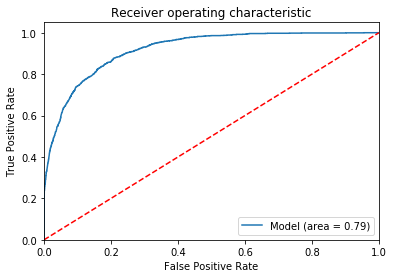

Number of mislabeled points out of a total 6033 points: 812 with precision: 0.865407


(0.8654069285595889, 0.13459307144041108)

In [24]:
# Побудуємо найкращу модель ще раз
col = cols[index]
X_train_i, X_test_i = X_train[col], X_test[col]
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
model.fit(X_train_i, y_train)
roc(model, X_test_i, y_test)
estimate(model, X_test_i, y_test)

# Випадковий ліс

In [14]:
# Вибір даних
# Виберемо вхідні параметри і вихідний параметр
X = fit_df.loc[:, df.columns != 'result']
y = fit_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data

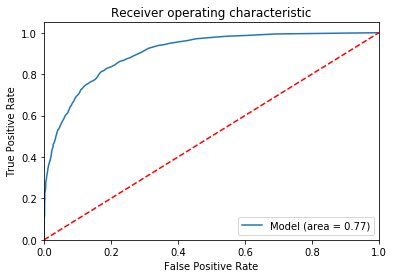

Number of mislabeled points out of a total 6033 points: 901 with precision: 0.850655


(0.8506547323056523, 0.14934526769434775)

In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
roc(model, X_test, y_test)
estimate(model, X_test, y_test)

In [ ]:
# Застереження: код працює повільно
# Цей код може працювати повільно, оскільки він створює багато моделей, кількість яких рівна 2^14 - 1, 
# адже ми перебираємо всі підмножини колонок, окрім порожної
X = fit_df.loc[:, df.columns != 'result']
cols = subsets(column_names[:-1])[1:]

precision = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # split data
for col in cols:
    X_train_i, X_test_i = X_train[col], X_test[col]
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train_i, y_train)
    print(col)
    prec, _ = estimate(model, X_test_i, y_test)
    precision.append(prec)

['age']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['workclass']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['age', 'workclass']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677
['fnlwgt']
Number of mislabeled points out of a total 6033 points: 1995 with precision: 0.669319
['age', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1895 with precision: 0.685894
['workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 2013 with precision: 0.666335
['age', 'workclass', 'fnlwgt']
Number of mislabeled points out of a total 6033 points: 1874 with precision: 0.689375
['education']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'education']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['workclass', 'education']
Number of mislabeled points out of a 

['age', 'workclass', 'occupation']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788
['fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1919 with precision: 0.681916
['age', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1666 with precision: 0.723852
['workclass', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1917 with precision: 0.682248
['age', 'workclass', 'fnlwgt', 'occupation']
Number of mislabeled points out of a total 6033 points: 1570 with precision: 0.739765
['education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['age', 'education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['workclass', 'education', 'occupation']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'workclass', 'education',

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['relationship']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'relationship']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['workclass', 'relationship']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'workclass', 'relationship']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['fnlwgt', 'relationship']
Number of mislabeled points out of a total 6033 points: 1651 with precision: 0.726338
['age', 'fnlwgt', 'relationship']
Number of mislabeled points out of a total 6033 po

['age', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['workclass', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['ag

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1114 with precision: 0.815349
['education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'fnl

['workclass', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['age', 'workclass', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['age', 'fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['education-num', 'marital-status', 'race']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
[

['fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1446 with precision: 0.760318
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['workclass', 'education', 'marital-status', 'occupation', 'race']
Number of mislabeled points out of a total 6033 points: 10

['fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['workclass', 'marital-status', 'relationship', 'race']
Number of mislabeled points out of 

['age', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['workclass', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'workclass', 'fnlwgt', 'education-num', 'occupatio

['workclass', 'sex']
Number of mislabeled points out of a total 6033 points: 1480 with precision: 0.754683
['age', 'workclass', 'sex']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1912 with precision: 0.683076
['age', 'fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1841 with precision: 0.694845
['workclass', 'fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1935 with precision: 0.679264
['age', 'workclass', 'fnlwgt', 'sex']
Number of mislabeled points out of a total 6033 points: 1818 with precision: 0.698657
['education', 'sex']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'education', 'sex']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['workclass', 'education', 'sex']
Number of mislabeled points out of a total 6033 points: 1340 with pr

['occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['workclass', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['age', 'workclass', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1803 with precision: 0.701144
['age', 'fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['workclass', 'fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1791 with precision: 0.703133
['age', 'workclass', 'fnlwgt', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313
['education', 'o

['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex']
Number of mislabeled points out of a total 6033 points: 1304

['age', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['workclass', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['age', 'workclass', 'fnlwgt', 'educatio

['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1274 with precision: 0.788828
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1451 with precision: 0.759489
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass'

['age', 'workclass', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1718 with precision: 0.715233
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1522 with precision: 0.747721
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1710 with precision: 0.716559
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1513 with precision: 0.749213
['age', 'marital-status', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.

['fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1699 with precision: 0.718382
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1606 with precision: 0.733797
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['education', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['age', 'education', 'education-num', 'occupation', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workclass', 'education', 'education-num', 'occupation', 'race', 'sex']
Number of mislab

['education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['workclass', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'workclass', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249
['fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1155 with preci

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.817669
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

['age', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1434 with precision: 0.762307
['age', 'workclass', 'fnlwgt', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 945 with precision: 0.843362
['age', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 968 with precision: 0.839549
['workclass', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['age', 'workclass', 'education', 'marital-status', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.8

['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1562 with precision: 0.741091
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1231 with precision: 0.795956
['marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 955 with precision: 0.841704
['age', 'marital-status', 'occupation', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['workclass', 'marital-status', 'occupation', 'capital-ga

['age', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['workclass', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['age', 'workclass', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain']
Number of mislab

['fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 925 with precision: 0.846677
['age', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 998 with precision: 0.834576
['workclass', 'education', 'occupation', 'relationship', 'capital-gain']
Number of mislabel

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 959 with precision: 0.841041
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['workclass', 'education', 'education-num', 'marital-status'

['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['education-num', 'marital-status', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['age', 'education-num', 'marital-status', 'r

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 959 with precision: 0.841041
['age', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['workclass', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'fnlwgt', 'marital-status', 'occupation', 'ra

['age', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 971 with precision: 0.839052
['workclass', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1213 with precision: 0.798939
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1205 with precision: 0.800265
['age', 'workclass', 'fnlwgt', 'education-num', 

['age', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['workclass', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['age', 'workclass', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1242 with precision: 0.794132
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race'

['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 939 with precision: 0.844356
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'rela

['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['age', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 986 with precision: 0.836566
['workclass', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'workclass', 'education', 'marital-status', 'sex', 'capital-gain']
Number of mislabeled points out

['age', 'workclass', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1501 with precision: 0.751202
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['marital-status', 'occupation', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 958 with precision

['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 941 with precision: 0.844025
['age', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['workclass', 'education-num', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'workclass', 'education-num', 'relationship', 'sex', 'capit

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1195 with precision: 0.801923
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['age', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 984 with precision: 0.836897
['workclass', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 931 with precision: 0.845682
['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 968 with precision: 0.839549
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['age', 'workclass', 'education-num', 'marital-status', 'occupa

['marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['age', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1374 with precision: 0.772253
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6

['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1453 with precision: 0.759158
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1100 with precision: 0.

['workclass', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'workclass', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['education', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled p

['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1155 with precision: 0.808553
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['education', 'education-num', 'marital-status', 'relat

['marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled points out of a total 6033 points: 1270 with precision: 0.789491
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain']
Number of mislabeled poin

['education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['age', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['workclass', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1310 with precision: 0.782861
['age', 'workclass', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1717 with precision: 0.715399
['age', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1549 with precision: 0.743245
['workclass', 'fnlwgt', 'education-num', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1710 with precision: 0.716559
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-loss']
Number

['age', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1710 with precision: 0.716559
['age', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1672 with precision: 0.722858
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['workclass', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'relationship', 'capital-loss']
Numbe

['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1391 with precision: 0.769435
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1247 with precision: 0.793303
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1349 with precision: 0.776396
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['education', 'education-num', 'marital-status', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 p

['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-loss']
Number of mislabeled points out of a total 6033 poi

['education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['age', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1316 with precision: 0.781866
['age', 'workclass', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1750 with precision: 0.709929
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1535 with precision: 0.745566
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss']
Number of

['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1404 with precision: 0.767280
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1629 with precision: 0.729985
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['age', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['workclass', 'education-num', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-l

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1400 with precision: 0.767943
['age', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['workclass', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['age', 'workclass', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1237 with precision: 0.794961
['fnlwgt', 'relationship', 'race', 'capital-loss']
Nu

['age', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss']
Number of mislabeled poi

['marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1148 with precision: 0.809713
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1207 with

['age', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1229 with precision: 0.796287
['workclass', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['age', 'workclass', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['fnlwgt', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1647 with precision: 0.727001
['age', 'fnlwgt', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1479 with precision: 0.754848
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1643 with precision: 0.727665
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1420 with precision: 

['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442
['age', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['workclass', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'workclass', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1631 with precision: 0.729654
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['age', 'workclass', 'fnlwgt', 'education', 'education-nu

['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1216 with precision: 0.798442
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194
['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss']
Number of mi

['fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1649 with precision: 0.726670
['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1629 with precision: 0.729985
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['workclass', 'education-num', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['workclass', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age', 'workclass', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1731 with precision: 0.713078
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out

['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-l

['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1513 with precision: 0.749213
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1534 with precision: 0.74573

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1037 with precision: 0.828112
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss']
Number

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1160 with precision: 0.807724
['ag

['marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 873 with precision: 0.855296
['age', 'workclass', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 959 with precision: 0.841041
['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'fnlwgt', 'marita

['education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 883 with precision: 0.853638
['age', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 941 with precision: 0.844025
['workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1160 with precision: 0.807724
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['workclass', 'fnlwgt', '

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 909 with precision: 0.849329
['workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 871 with precision: 0.855627
['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of

['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 875 with precision: 0.854964
['age', 'education-

['age', 'workclass', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1486 with precision: 0.753688
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['marital-status', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 

['age', 'workclass', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1426 with precision: 0.763633
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382
['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 10

['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 953 with precision: 0.842035
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 984 with precision: 0.836897
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0

['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 894 with precision: 0.851815
['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-ga

['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 928 with precision: 0.846179
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['education', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 883 with precision: 0.853638
['age', 'education', 'education-num', 'o

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 936 with precision: 0.844853
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1065 with precision: 0.823471
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['workclass', 'sex', 'capital-gain', 'capital-loss']
Numbe

['education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992
['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 964 with precision: 0.840212
['fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1154 with precision: 0.808719
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1

['marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 904 with precision: 0.850157
['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 891 with precision: 0.852312
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 965 with precision: 0.840046
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1018 with precision

['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1141 with precision: 0.810874
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'workclass', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 po

['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a 

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 971 with precision: 0.839052
['education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 949 with precision: 0.842698
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 878 with precision: 0.854467
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 967 with precision: 0.839715
['fnlwgt', 'e

['fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1377 with precision: 0.771755
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1037 with p

['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028

['education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 892 with precision: 0.852147
['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 954 with precision: 0.841870
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'fnlwgt', 'education-num', 'mar

['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1019 with precision: 0.831096
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1126 with precision: 0.813360
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'marital-status', 'relat

['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 972 with precision: 0.838886
['education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 888 with precision: 0.852810
['age', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 963 with precision: 0.840378
['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['fnlwgt', 'education', 'occupation', 'relationship', 'race', '

['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 897 with precision: 0.851318
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 955 with precision: 0.841704
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 913 with precision: 0.848666
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss']
Number of mislabeled points out of a total 60

['age', 'workclass', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['fnlwgt', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1652 with precision: 0.726173
['age', 'fnlwgt', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1515 with precision: 0.748881
['workclass', 'fnlwgt', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1594 with precision: 0.735787
['age', 'workclass', 'fnlwgt', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['education', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['age', 'education', 'marital-status', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['work

['workclass', 'education', 'education-num', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['age', 'workclass', 'education', 'education-num', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1638 with precision: 0.728493
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1617 with precision: 0.731974
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1336 with precision: 0.

['workclass', 'fnlwgt', 'education', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['age', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['workclass', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['age', 'workclass', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['fnlwgt', 'education-num', 'relationship', 'hours-per-week']
Number of mislabeled poin

['occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['workclass', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1114 with precision: 0.815349
['age', 'workclass', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['fnlwgt', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1448 with precision: 0.759987
['age', 'fnlwgt', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['workclass', 'fnlwgt', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 poi

['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1261 with precision: 0.790983
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1092 with precision: 0.818996
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relations

['workclass', 'fnlwgt', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1435 with precision: 0.762142
['education', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['age', 'education', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['workclass', 'education', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['age', 'workclass', 'education', 'marital-status', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['fnlwgt', 'education', 'marital-status', 'race', 'hours-per-week']
N

['workclass', 'education', 'education-num', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1652 with precision: 0.726173
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1611 with precision: 0.732969
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'hours-per-week']
Number of mislabeled points out

['age', 'workclass', 'education', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['fnlwgt', 'education', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['age', 'fnlwgt', 'education', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1334 with precision: 0.778883
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['education-num', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['age', 'education-num', 'relationship', 'ra

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['age', 'occupation', 'relationship', 'race', 'hours-per-week']
Numbe

['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['education-num', 'marital-sta

['age', 'fnlwgt', 'education', 'education-num', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1424 with precision: 0.763965
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1621 with precision: 0.731311
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1354 with precision: 0.775568
['marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['age', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1415 with precision: 0.765457
['workclass', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'marital-status', 'sex', 'hours-per-week']
Number of mislabeled points ou

['workclass', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'workclass', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1491 with precision: 0.752859
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['education', 'education-num'

['age', 'workclass', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['fnlwgt', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1665 with precision: 0.724018
['age', 'fnlwgt', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1505 with precision: 0.750539
['workclass', 'fnlwgt', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1573 with precision: 0.739267
['age', 'workclass', 'fnlwgt', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1393 with precision: 0.769103
['education', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['age', 'education', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1

['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week']
Number of mis

['fnlwgt', 'education-num', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1626 with precision: 0.730482
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1605 with precision: 0.733963
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1337 with precision: 0.778386
['education', 'education-num', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['age', 'education', 'education-num', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'education', 'education-num', 'race', 'sex', 'hours

['workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1633 with precision: 0.729322
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['education', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['age', 'education', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1367 with precision: 0.773413
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'education', 'occupation', 'race', 'sex'

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'workclass', 'education', 'educatio

['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1540 with precision: 0.744737
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1414 with precision: 0.765622
['education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1203 with precision: 0.800597
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabe

['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1254 with precision: 0.792143
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['education', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['age', 'education', 'education-num', 'occupation', 'relationship', 'rac

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['age', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['workclass', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1228 with precision: 0.796453
['age', 'workclass', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'capital-gain', 

['age', 'workclass', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1198 with precision: 0.801425
['age', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1046 with precision: 0.826620
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['education', 'education-num', 'marital-status', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a 

['fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['age', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1

['age', 'workclass', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['age', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1024 with precision: 0.830267
['education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 p

['occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['age', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 963 with precision: 0.840378
['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1262 with precision: 0.790817
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['workclass', 'fnlwgt', 'occu

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 980 with precision: 0.837560
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 920 with precision: 0.847505
['education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1032 with precision: 0.828941
['workcl

['fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1513 with precision: 0.749213
['age', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1476 with precision: 0.755346
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['age', 'marital-status', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1175 with pre

['fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1382 with precision: 0.770927
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890
['age', 'education-num', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points:

['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1135 with precision: 0.811868
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 973 with p

['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 965 with precision: 0.840046
['age', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1055 with precision: 0.825128
['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['fnlwgt', 'education', 'marital-status', 'relationship', 'race',

['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 992 with precision: 0.835571
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 963 with precision: 0.840378
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['education', 'educatio

['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 953 with precision: 0.842035
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 924 with precision: 0.846842
['sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 poin

['workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1022 with precision: 0.830598
['education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 978 with precision: 0.837892
['age', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['age', 'workclass', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled poin

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 992 with precision: 0.835571
['age', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week']
N

['workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 997 with precision: 0.834742
['age', 'workclass', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out 

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 978 with precision: 0.837892
['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 998 with precision: 0.834576
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1040 with precis

['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'workclass', 'fnlwgt', 'marita

['age', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1196 with precision: 0.801757
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['age', 'workclass', 'fnlwgt', 'education', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['age', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['workclass', 'education-num', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['ag

['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1006 with precision: 0.833250
['occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['age', 'occupation', 'race', 'sex

['age', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 955 with precision: 0.841704
['workclass', 'fnlwgt', 'educa

['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1040 with precision: 0.827615
['workclass', 'education', 'education-num', 'relation

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 985 with precision: 0.836731
['age', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 988 with precision: 0.836234
['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1041 with precision: 0.827449
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gai

['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1001 with precision: 0.834079
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 985 with precision: 0.836731
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week']
Number of mislabeled points out of 

['workclass', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['age', 'workclass', 'education', 'education-num', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1328 with precision: 0.779877
['fnlwgt', 'education', 'ed

['education', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'education', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'education', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'education', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1575 with precision: 0.738936
['age', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1290 with precision: 0.786176
['workclass', 'fnlwgt', 'education', 'occupat

['education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1264 with precision: 0.790486
['age', 'fnlwgt', 'education', 'edu

['education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1129 with precision: 0.812863
['workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['age', 'workclass', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week']
Number of m

['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['workclass', 'education', 'education-num', 'occupation',

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1417 with precision: 0.765125
['age', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1433 with precision: 0.762473
['workclass', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1399 with precision: 0.768109
['age', 'workclass', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1432 with precision: 0.762639
['fnlwgt', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1820 with precision: 0.698326
['age', 'fnlwgt', 'race', 'capital-loss', 'hours-per-week']
Number of mislab

['workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'workclass', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'capital-loss', 'hours-

['age', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['age', 'workclass', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1159 with precision: 0.807890
['fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1398 with precision: 0.768274
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points ou

['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['age', 'workclass', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points o

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1113 with precision: 0.815515
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a t

['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['workclass'

['age', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1291 with precision: 0.786010
['workclass', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['age', 'workclass', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['age', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1340 with precision: 0.777888
['workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1563 with precision: 0.740925
['age', 'workclass', 'fnlwgt', 'educatio

['age', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1317 with precision: 0.781701
['age', 'workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1618 with precision: 0.731808
['age', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1561 with precision: 0.741256
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'capit

['education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1092 with precision: 0.818996
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation'

['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1333 with precision: 0.779049
['age', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'marital-status', 'relationship', 'sex', 'capital-loss', 'hours-per-week

['workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1096 with precision: 0.818333
['age', 'workclass', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1171 with precision: 0.805901
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'rel

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1023 with precision: 0.830433
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points 

['workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1293 with precision: 0.785679
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1296 with precision: 0.785182
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1582 with precision: 0.737776
['age', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1407 with precision: 0.766783
['workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1490 with precision: 0.753025
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 p

['education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1283 with precision: 0.787336
['age', 'workclass', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1504 with precision: 0.750704
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabe

['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1199 with precision: 0.801260
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'hours-per-wee

['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1325 with precision: 0.780375
['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1092 with precision: 0.818996
['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1127 with precision: 0.813194
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1128 with precision: 0.813028
['fnlwgt', 'education', 'mar

['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['workclass', 'fnl

['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1079 with precision: 0.821150
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship'

['education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['age', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 931 with precision: 0.845682
['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 972 with precision: 0.838886
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1141 with precision: 0.810874
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of misla

['age', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1101 with precision: 0.817504
['workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1302 with precision: 0.784187
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1068 with precision: 0.822974
['education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1072 with precision: 0.822311
['age', 'education', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['workclass', 'education', 'education-num', 'occupation',

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 882 with precision: 0.853804
['relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['age', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['workclass', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1053 with precision: 0.825460
['age', 'workclass', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['fnlwgt', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 

['fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 956 with precision: 0.841538
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['education-num', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 905 with precision: 0.849992

['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1022 with precision: 0.830598
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 865 with precision: 0.856622
['education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 948 with precision: 0.842864
['age', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1001 with precision: 0.834079
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 

['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1180 with precision:

['age', 'workclass', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 974 with precision: 0.838555
['fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1160 with precision: 0.807724
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['education-num', 'mar

['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1267 with precision: 0.789988
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['age', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['age', 

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 886 with precision: 0.853141
['relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['age', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'workclass', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['fnlwgt', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-we

['workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 945 with precision: 0.843362
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 603

['workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['workclass', 'fnlwgt', 'education-num', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 603

['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 954 with precision: 0.841870
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 960 with precision: 0.840875
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 941 with precision: 0.844025
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',

['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1278 with precision: 0.788165
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 923 with precision: 0.847008
['age', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 977 with precision: 0.838057
['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'hour

['age', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'workclass', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['workclass', 'fnlwgt', 'education-num', 'occupation', 'se

['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 960 with precision: 0.840875
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-l

['age', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1269 with precision: 0.789657
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 919 with precision: 0.847671
['age', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 990 with precision: 0.835903
['workcla

['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 879 with precision: 0.854301
['education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 935 with precision: 0.845019
['age', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 989 with precision: 0.836068
['workclass', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 963 with prec

['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship'

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1093 with precision: 0.818830
['marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['age', 'workclass', 'marital-status', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['fnlwgt', 'marital-status', 'race', 'sex', 'capital-gain', 'capital

['age', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1114 with precision: 0.815349
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1098 with precision: 0.818001
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1040 with precision: 0.827615
['workclass', 'fnlwgt', 'education', '

['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 967 with precision: 0.839715
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 937 with precision: 0.844688
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 922 with precision: 0.847174
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
N

['age', 'workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 992 with precision: 0.835571
['fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1090 with precision: 0.819327
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week'

['workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['age', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 973 with precision: 0.838720
['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'w

['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 926 with precision: 0.846511
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capita

['workclass', 'fnlwgt', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1799 with precision: 0.701807
['age', 'workclass', 'fnlwgt', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1524 with precision: 0.747389
['education', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['age', 'education', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['workclass', 'education', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'workclass', 'education', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['fnlwgt', 'education', 'education-num', 'native-country']
Number of mislabeled points out of a total 6033 points: 1824 wit

['workclass', 'fnlwgt', 'education', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1733 with precision: 0.712747
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1386 with precision: 0.770264
['education-num', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['age', 'education-num', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1410 with precision: 0.766285
['workclass', 'education-num', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1352 with precision: 0.775899
['age', 'workclass', 'education-num', 'occupation', 'native-country']
Number of mislabeled points out of a total 6033 points: 1429 with precision: 0.763136
['fnlwgt', 'education-num', 'occupation', 'native-country']
Number of mislabeled points out of a to

['age', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['workclass', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1413 with precision: 0.765788
['age', 'workclass', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1322 with precision: 0.780872
['fnlwgt', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1648 with precision: 0.726836
['age', 'fnlwgt', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1605 with precision: 0.733963
['workclass', 'fnlwgt', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1674 with precision: 0.722526
['age', 'workclass', 'fnlwgt', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1546 with precision: 0.743743
['education', 'relationship', 'na

['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1390 with precision: 0.769601
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1245 with precision: 0.793635
['education', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'education', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'native-country']
Numbe

['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1172 with precision: 0.805735
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
Number of mislabeled po

['workclass', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'workclass', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['fnlwgt', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1816 with precision: 0.698989
['age', 'fnlwgt', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1608 with precision: 0.733466
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1798 with precision: 0.701972
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1552 with precision: 0.742748
['marital-status', 'race', 'n

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['workclass', 'education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['fnlwgt', 'education-num', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1764 with precision: 0.707608
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'na

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1462 with precision: 0.757666
['age', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1411 with precision: 0.766120
['age', 'workclass', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['fnlwgt', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1632 with precision: 0.729488
['age', 'fnlwgt', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a tot

['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'native

['age', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1465 with precision: 0.757169
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
Number of mislabeled points ou

['age', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1341 with precision: 0.777723
['age', 'workclass', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1728 with precision: 0.713575
['age', 'fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1498 with precision: 0.751699
['workclass', 'fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1698 with precision: 0.718548
['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1449 wi

['workclass', 'fnlwgt', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1773 with precision: 0.706116
['age', 'workclass', 'fnlwgt', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1440 with precision: 0.761313
['education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1287 with precision: 0.786673
['age', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1314 with precision: 0.782198
['workclass', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['fnlwgt', 'education', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a

['education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1073 with precision: 0.822145
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 

['age', 'workclass', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1168 with precision: 0.806398
['fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1419 with precision: 0.764794
['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['education-num', 'marital-status', 'relationship', 'sex', 'native-country']
Number of mislabeled points 

['workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1311 with precision: 0.782695
['age', 'workclass', 'fnlwgt', 'education', 'education-nu

['education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1281 with precision: 0.787668
['workclass', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1360 with precision: 0.774573
['age', 'workclass', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1699 with precision: 0.718382
['age', 'fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['workclass', 'fnlwgt', 'education', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1691 with

['fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1430 with precision: 0.762970
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1396 with precision: 0.768606
['age', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 132

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1112 with precision: 0.815680
['education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1121 with precision: 0.814189
['age', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1170 with precision: 0.806067
['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'native-coun

['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1232 with precision: 0.795790
['marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1466 with precision: 0.757003
['age', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a

['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1344 with precision: 0.777225
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['education-num', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numb

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of mislabeled points out of a to

['workclass', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 939 with precision: 0.844356
['age', 'workclass', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['age', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1080 w

['age', 'workclass', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282
['fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1553 with precision: 0.742582
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1511 with precision: 0.749544
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['marital-status', 'occupation', 'capital-gain', 'native-country']
Number o

['workclass', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['age', 'workclass', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1009 with precision: 0.832753
['fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['age', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precisio

['age', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1227 with precision: 0.796619
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['workclas

['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1240 with precision: 0.794464
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1031 with precision: 0.829107
['education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 934 with precision: 0.845185
['age', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 997 with precision: 0.834742
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['age', 'workclass', 'education', 'marital-sta

['fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1521 with precision: 0.747887
['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1544 with precision: 0.744074
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1320 with precision: 0.781203
['education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['age', 'education', 'education-num', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['workclass

['fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1606 with precision: 0.733797
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1614 with precision: 0.732471
['age', 'workclass', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1303 with precision: 0.784021
['education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['age', 'education', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1233 with precision: 0.795624
['workclass', 'education', 'o

['workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 930 with precision: 0.845848
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1027 with precision: 0.829770
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['age', 'workclass', 'fnlwgt'

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1200 with precision: 0.801094
['age', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1160 with precision: 0.807724
['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislab

['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1040 with precision: 0.827615
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 977 with precision: 0.838057
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 950 with precision: 0.842533
['education-num', 'occupation', 'relations

Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 982 with precision: 0.837229
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 961 with precision: 0.840709
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 951 with precision: 0.842367
['age', 'education', 'education-num', 'marital-status', 'o

Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1343 with precision: 0.777391
['workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1427 with precision: 0.763468
['age', 'workclass', 'fnlwgt', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 943 with precision: 0.843693
['age', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 976 with precision: 0.838223
['workclass', 'education', 'marital-status', 'sex', 'capital-gain', 'native-country

['fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1442 with precision: 0.760981
['age', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1149 with precision: 0.809547
['workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1439 with precision: 0.761479
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1092 with precision: 0.818996
['age', 'education', 'education-num', 'occupation', 'sex', 'capital-gain', 'native-country']
Number of mislabele

['relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['age', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1131 with precision: 0.812531
['workclass', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['age', 'workclass', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['fnlwgt', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['age', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['workclass', 'fnlwgt', 'relationship', 'sex', 'capital-gain', 'nativ

['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 949 with precision: 0.842698
['age', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 947 with precision: 0.843030
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['fnlwgt', 'education-num', 'marital-statu

['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 992 with precision: 0.835571
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033

['fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1586 with precision: 0.737113
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1467 with precision: 0.756837
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1635 with precision: 0.728991
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1445 with precision: 0.760484
['education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1115 with precision: 0.815183
['age', 'education', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['workclass', 'education', 'race', 'sex', 'capital-gain', 'native-count

['fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['age', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1171 with precision: 0.805901
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['education', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 957 with precision: 0.841372
['age', 'education', 'education-num', 'marital-status

['age', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1005 with precision: 0.833416
['workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['age', 'workclass', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['age', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'native

['age', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.823802
['education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 944 with precision: 0.843527
['age', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'native-countr

['education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 958 with precision: 0.841207
['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 997 with precision: 0.834742
['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 978 with precision: 0.837892
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a to

['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 959 with precision: 0.841041
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1064 with precision: 0.823637
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.79910

['age', 'fnlwgt', 'education', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1537 with precision: 0.745235
['workclass', 'fnlwgt', 'education', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1710 with precision: 0.716559
['age', 'workclass', 'fnlwgt', 'education', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1485 with precision: 0.753854
['education-num', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['age', 'education-num', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1266 with precision: 0.790154
['workclass', 'education-num', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1304 with precision: 0.783855
['age', 'workclass', 'education-num', 'capital-loss', 'native-country']
Number of mislabeled p

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1192 with precision: 0.802420
['occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1421 with precision: 0.764462
['age', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['workclass', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1346 with precision: 0.776894
['age', 'workclass', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['fnlwgt', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1821 with precision: 0.698160
['age', 'fnlwgt', 'occupation', 'capital-loss', 'native-country']
Number of 

['education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['age', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1028 with precision: 0.829604
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1277 with precision: 0.788331
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'native-country']

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1181 with precision: 0.804243
['marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1225 with precision: 0.796950
['workclass', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['age', 'workclass', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1253 with precision: 0.792309
['fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1546 wit

['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1250 with precision: 0.792806
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1045 with precision: 0.826786
['age', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['workclass', 'education-num', 'occupation', 'relationship', 'capital-loss', 'native-country']


['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1052 with precision: 0.825626
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1049 with precision: 0.826123
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1129 with precision: 0.812863
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'native-country']
Number of mislabeled points out of a tota

['age', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['workclass', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1076 with precision: 0.821648
['age', 'workclass', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1379 with precision: 0.771424
['age', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a

['education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1392 with precision: 0.769269
['workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1326 with precision: 0.780209
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1389 with precision: 0.769766
['fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1693 with precision: 0.719377
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'race', 'capital-loss',

['fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898
['age', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1489 with precision: 0.753191
['workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1574 with precision: 0.739102
['age', 'workclass', 'fnlwgt', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['age', 'education', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1107 with precision: 0.816509
['workclass', 'ed

['workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['age', 'workclass', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1150 with precision: 0.809382
['fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1365 with precision: 0.773744
['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1176 with precision: 0.805072
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1330 with precision: 0.779546
['age', 'workclas

['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1108 with precision: 0.816343
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1067 with precision: 0.823139
['marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1080 with precision: 0.820985
['age', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['

['age', 'workclass', 'fnlwgt', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1675 with precision: 0.722360
['education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1209 with precision: 0.799602
['workclass', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'workclass', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['fnlwgt', 'education', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1640 with precision: 0.728162
['age', 'fnlwgt', 'education', 'sex', 'capital-loss', 'native-country']
Number of misla

['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1078 with precision: 0.821316
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1394 with precision: 0.768938
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['workclass', 'fnlwgt', 'education', 'education-num',

['education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1038 with precision: 0.827946
['age', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1134 with precision: 0.812034
['workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1033 with precision: 0.828775
['age', 'workclass', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'sex', 'capital-loss',

['workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1356 with precision: 0.775236
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1175 with precision: 0.805238
['education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['age', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['age', 'workclass', 'education', 'education-num', 'relationship', 'sex', 'capital-

['workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'workclass', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1364 with precision: 0.773910
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled poin

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1204 with precision: 0.800431
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1047 with precision: 0.826455
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 

['workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1300 with precision: 0.784518
['age', 'workclass', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1305 with precision: 0.783690
['fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1626 with precision: 0.730482
['age', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1452 with precision: 0.759324
['workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1625 with precision: 0.730648
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'sex', 'capital-lo

['education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1257 with precision: 0.791646
['age', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1309 with precision: 0.783027
['workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['age', 'workclass', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1331 with precision: 0.779380
['fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1606 with precision: 0.733797
['age', 'fnlwgt', 'education', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a tota

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1095 with precision: 0.818498
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with pr

['marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1406 with precision: 0.766948
['age', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1255 with precision: 0.791977
['workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'workclass', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1252 with precision: 0.792475
['fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1520 with precision: 0.748052
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']

['workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1042 with precision: 0.827283
['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1137 with precision: 0.811537
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1098 with precision: 0.818001
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'workclass', '

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1106 with precision: 0.816675
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1251 with precision: 0.792640
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1190 with precision: 0.802752
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-loss',

['marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['age', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['workclass', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'workclass', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1280 with precision: 0.787834
['age', 'fnlwgt', 'marital-status', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1239 with precision: 0.794630
['w

['workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1140 with precision: 0.811039
['education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1089 with precision: 0.819493
['age', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1081 with precision: 0.820819
['age', 'workclass', 'education-num', 'occupation', 'capital-gain', 'capital-loss', 'native-cou

['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 952 with precision: 0.842201
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 870 with precision: 0.855793
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 977 with precision: 0.838057
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points

['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1323 with precision: 0.780706
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 890 with precision: 0.852478
['age', 'education', 'marital-status', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 921 with precision: 0.847340
['workclass', 'education', 'marital-status',

['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 918 with precision: 0.847837
['education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 863 with precision: 0.856953
['age', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 977 with precision: 0.838057
['workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 881 with precision: 0.853970
['age', 'workclass', 'education-num', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['fnlwgt', 'educati

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 907 with precision: 0.849660
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 899 with precision: 0.850986
['age', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 962 with precision: 0.840544
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 896 with precision: 0.851484
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital

['fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['age', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1338 with precision: 0.778220
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 887 with precision: 0.852975
['age', 'education', 'marital-status', 'race', 'capital-gain', 'capital-loss', 'native-countr

['education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['age', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1147 with precision: 0.809879
['workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1110 with precision: 0.816012
['age', 'workclass', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1397 with precision: 0.768440
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'capital-gain

['age', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 900 with precision: 0.850820
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1088 with precision: 0.819659
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-gain', 'capital-loss', 'nati

['age', 'workclass', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1286 with precision: 0.786839
['age', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1174 with precision: 0.805404
['edu

['age', 'workclass', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 997 with precision: 0.834742
['fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 930 with precision: 0.845848
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 

['workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 911 with precision: 0.848997
['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 987 with precision: 0.836400
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1083 with precision: 0.820487
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 917 with precision: 0.848003
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capit

['age', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1244 with precision: 0.793801
['workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1405 with precision: 0.767114
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1208 with precision: 0.799768
['marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1091 with precision: 0.819161
['age', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1071 with precision: 0.822476
['workclass', 'marital-status', 'sex', 'capital-gain', 'capital-loss', 'nativ

['age', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['age', 'workclass', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1376 with precision: 0.771921
['age', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['workclass', 'fnlwgt', 'education', 'occupation', 'sex', 'capital-gain', 'cap

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 954 with precision: 0.841870
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 940 with precision: 0.844190
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1043 with precision: 0.827118
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled po

['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1037 with precision: 0.828112
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['age', 'marital-status', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1063 with precision: 0.8238

['age', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 980 with precision: 0.837560
['education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 872 with precision: 0.855462
['age', 'education', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 970 with precision: 0.839218
['workclass', 'education', 'oc

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 938 with precision: 0.844522
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1050 with precision: 0.825957
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 902 with precision: 0.850489
['education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 885 with precision: 0.853307
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'capital-loss

['workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1355 with precision: 0.775402
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1054 with precision: 0.825294
['age', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['workclass', 'education', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'workclass', 'education', 'educatio

['occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.815846
['age', 'workclass', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1437 with precision: 0.761810
['age', 'fnlwgt', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled po

['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 906 with precision: 0.849826
['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 990 with precision: 0.835903
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1085 with precision: 0.820156
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 916 with precision: 0.848168
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled 

['workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 927 with precision: 0.846345
['age', 'workclass', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 976 with precision: 0.838223
['fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 0.832256
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1111 with precision: 0.8

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 942 with precision: 0.843859
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 973 with precision: 0.838720
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relat

['age', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 946 with precision: 0.843196
['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 906 with precision: 0.849826
['age', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 966 with precision: 0.839881
['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country']
Number of mislabeled p

['education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1383 with precision: 0.770761
['workclass', 'education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1359 with precision: 0.774739
['age', 'workclass', 'education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1401 with precision: 0.767777
['fnlwgt', 'education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1728 with precision: 0.713575
['age', 'fnlwgt', 'education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1500 with precision: 0.751367
['workclass', 'fnlwgt', 'education', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6

['age', 'workclass', 'education', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1372 with precision: 0.772584
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['occupation', 'hours-per-week', 'native-coun

['fnlwgt', 'education', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1308 with precision: 0.783192
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1220 with precision: 0.797779
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1066 with precision: 0.823305
['education-num', 'marital-status', 'occupation', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1122 with precision: 0.814023
['age', 'education-num', 'marital-status', 'occupation', 'hours-per-week', '

['age', 'workclass', 'education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1371 with precision: 0.772750
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1197 with precision: 0.801591
['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1357 with precision: 0.775070
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1183 with precision: 0.803912
['marital-status', 'relationship', 'hours-per-week', 'n

['education', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'education', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['workclass', 'education', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1123 with precision: 0.813857
['age', 'workclass', 'education', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['fnlwgt', 'education', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1284 with precision: 0.787171
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled po

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1273 with precision: 0.788994
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1099 with precision: 0.817835
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1194 with precision: 0.802089
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1056 with precision: 0.824963
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 point

['fnlwgt', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1618 with precision: 0.731808
['age', 'fnlwgt', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1457 with precision: 0.758495
['workclass', 'fnlwgt', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1533 with precision: 0.745898
['age', 'workclass', 'fnlwgt', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1422 with precision: 0.764296
['education', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1169 with precision: 0.806232
['age', 'education', 'marital-status', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.

['age', 'workclass', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1408 with precision: 0.766617
['fnlwgt', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1638 with precision: 0.728493
['age', 'fnlwgt', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1335 with precision: 0.778717
['workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1569 with precision: 0.739930
['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1306 with precision: 0.783524
['education', 'education-num', 'occupation', 'race', 'hours-per-week', 'native-country']
N

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1087 with precision: 0.819824
['relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1438 with precision: 0.761644
['age', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['workclass', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1380 with precision: 0.771258
['age', 'workclass', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1351 with precision: 0.776065
['fnlwgt', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1619 with precision: 0

['age', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.784684
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1188 with precision: 0.803083
['education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['age', 'education-num', 'marital-status', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['workclass', 'education-

['education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['age', 'workclass', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1116 with precision: 0.815017
['fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'race', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.78

['sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1516 with precision: 0.748715
['age', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1469 with precision: 0.756506
['workclass', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1493 with precision: 0.752528
['age', 'workclass', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1483 with precision: 0.754185
['fnlwgt', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1888 with precision: 0.687055
['age', 'fnlwgt', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1668 with precision: 0.723521
['workclass', 'fnlwgt', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1839 with precision: 0.695177


['age', 'workclass', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1132 with precision: 0.812365
['fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1362 with precision: 0.774242
['age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1185 with precision: 0.803580
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1184 with precision: 0.803746
['education', 'education-num', 'marital-status', 'sex', 'hours-per-week', '

['age', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1224 with precision: 0.797116
['workclass', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'workclass', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1191 with precision: 0.802586
['fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1436 with precision: 0.761976
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1202 with precision: 0.800762
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled poi

['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['age', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['workclass', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1142 with precision: 0.810708
['age', 'workclass', 'education-num', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled po

['workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1151 with precision: 0.809216
['age', 'workclass', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1350 with precision: 0.776231
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1193 with precision: 0.802254
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out o

['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1207 with precision: 0.799934
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1358 with precision: 0.774905
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1158 with precision: 0.808056
['education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1139 with precision: 0.811205
['age', 'education', 'marital-status', 'occupation', 'relationship', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1167 with precision: 0.806564
['workc

['education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1332 with precision: 0.779214
['age', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1319 with precision: 0.781369
['workclass', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1361 with precision: 0.774407
['age', 'workclass', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1324 with precision: 0.780540
['fnlwgt', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1605 with precision: 0.733963
['age', 'fnlwgt', 'education-num', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1366 with precision: 0.773579
['w

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1307 with precision: 0.783358
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1402 with precision: 0.767611
['age', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1375 with precision: 0.772087
['workclass', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1409 with precision: 0.766451
['age', 'workclass', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mis

['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1114 with precision: 0.815349
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1249 with precision: 0.792972
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1094 with precision: 0.818664
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1186 with precision: 0.803415
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1091 with preci

['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1189 with precision: 0.802917
['education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1141 with precision: 0.810874
['age', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1164 with precision: 0.807061
['workclass', 'education', 'education-num', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1146 with precision: 0.810045
['age', 'workclass', 'education',

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1162 with precision: 0.807393
['age', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1248 with precision: 0.793138
['workclass', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1178 with precision: 0.804741
['age', 'workclass', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1179 with precision: 0.804575
['fnlwgt', 'occupation', 'relationship', 'race', 'sex', 

['age', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1152 with precision: 0.809050
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1133 with precision: 0.812200
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1097 with precision: 0.818167
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1223 with precision: 0.797282
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'hours-per-week', 'native-country']
Number of mislabeled poi

['fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1477 with precision: 0.755180
['age', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1459 with precision: 0.758163
['age', 'workclass', 'fnlwgt', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1163 with precision: 0.807227
['age', 'education', 'education-num', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a 

['age', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['workclass', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1210 with precision: 0.799436
['age', 'workclass', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1214 with precision: 0.798773
['fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1543 with precision: 0.744240
['age', 'fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1272 with precision: 0.789160
['workclass', 'fnlwgt', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1481 with precision: 0

['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1086 with precision: 0.819990
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 912 with precision: 0.848831
['education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 996 with precision: 0.834908
['age', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1017 with precision: 0.831427
['workclass', 'education-num', 'marital-status', 'occupation', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.83706

['age', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1034 with precision: 0.828609
['workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 998 with precision: 0.834576
['age', 'workclass', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['age', 'fnlwgt', 'education', 'education-num', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['workcla

['workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 975 with precision: 0.838389
['age', 'workclass', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1036 with precision: 0.828278
['fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['age', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'capital-gai

['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 980 with precision: 0.837560
['fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 945 with precision: 0.843362
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week', 'nativ

['age', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1265 with precision: 0.790320
['workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1447 with precision: 0.760152
['age', 'workclass', 'fnlwgt', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1217 with precision: 0.798276
['education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1161 with precision: 0.807558
['age', 'education', 'education-num', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1221 with precision: 0.797613
['workclass', 'education', 'education-num', 'race', 'capital-gain', 'hours-pe

['occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1211 with precision: 0.799271
['age', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1260 with precision: 0.791149
['workclass', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1212 with precision: 0.799105
['age', 'workclass', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1271 with precision: 0.789325
['fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218
['age', 'fnlwgt', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 point

['age', 'workclass', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 988 with precision: 0.836234
['fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1118 with precision: 0.814686
['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 960 with precision: 0.840875
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1069 with precision: 0.822808
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points 

['fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1130 with precision: 0.812697
['age', 'workclass', 'fnlwgt', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 995 with precision: 0.835074
['education', 'education-num', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 959 with precision: 0.841041
['age', '

['fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1138 with precision: 0.811371
['age', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1025 with precision: 0.830101
['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1109 with precision: 0.816178
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'na

['fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1222 with precision: 0.797447
['age', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1165 with precision: 0.806895
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 981 with precision: 0.837394
['education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabele

['fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1384 with precision: 0.770595
['age', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1226 with precision: 0.796784
['workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1403 with precision: 0.767446
['age', 'workclass', 'fnlwgt', 'education', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1145 with precision: 0.810211
['education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1102 with precision: 0.817338
['age', 'education-num', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a 

['education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 983 with precision: 0.837063
['age', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1013 with precision: 0.832090
['age', 'workclass', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1008 with precision: 0.832919
['fnlwgt', 'education', 'education-num', 'marital-status', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1170 with p

['age', 'workclass', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1062 with precision: 0.823968
['fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1238 with precision: 0.794795
['age', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1044 with precision: 0.826952
['workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1171 with precision: 0.805901
['age', 'workclass', 'fnlwgt', 'marital-status', 'occupation', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 985 with precision: 0.836731
['education

['fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1153 with precision: 0.808884
['age', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1018 with precision: 0.831261
['workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1143 with precision: 0.810542
['age', 'workclass', 'fnlwgt', 'education', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1000 with precision: 0.834245
['education-num', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 954 with precision: 0.841870
['age', 'education-num', 'relationship', '

['age', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1002 with precision: 0.833913
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1084 with precision: 0.820322
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 988 with precision: 0.836234
['education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 978 with precision: 0.837892
['age', 'education', 'education-num', 'marital-status', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']


Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852
['age', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 945 with precision: 0.843362
['workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1048 with precision: 0.826289
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 934 with precision: 0.845185
['marital-status', 'occupation', 'relationship', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1011 with precision: 0.832422
['age', 'marital-status', 'occupat

['workclass', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1230 with precision: 0.796121
['age', 'workclass', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1241 with precision: 0.794298
['fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1587 with precision: 0.736947
['age', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1381 with precision: 0.771092
['workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1517 with precision: 0.748550
['age', 'workclass', 'fnlwgt', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 p

['workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1125 with precision: 0.813526
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 972 with precision: 0.838886
['age', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1021 with precision: 0.830764
['workclass', 'education-num', 'marital-status', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1012 with precision: 

['age', 'workclass', 'fnlwgt', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1058 with precision: 0.824631
['education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1173 with precision: 0.805569
['age', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1166 with precision: 0.806730
['workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1182 with precision: 0.804078
['age', 'workclass', 'education', 'education-num', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a to

['workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1051 with precision: 0.825791
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1219 with precision: 0.797945
['age', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1157 with precision: 0.808221
['workclass', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1184 with precis

['age', 'workclass', 'fnlwgt', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1187 with precision: 0.803249
['education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 993 with precision: 0.835405
['age', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1016 with precision: 0.831593
['age', 'workclass', 'education', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled poin

['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1022 with precision: 0.830598
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 919 with precision: 0.847671
['education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 994 with precision: 0.835240
['age', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 991 with precision: 0.835737
['workclass', 'education-num', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabele

['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 969 with precision: 0.839383
['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1077 with precision: 0.821482
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 929 with precision: 0.846014
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1020 with precision: 0.830930
['age', 'workclass', 'fnlwgt', 'education-num', 'marital

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1339 with precision: 0.778054
['age', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1288 with precision: 0.786508
['workclass', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1294 with precision: 0.785513
['age', 'workclass', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'marital-status', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 poin

['fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1564 with precision: 0.740759
['age', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1285 with precision: 0.787005
['workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1495 with precision: 0.752196
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1258 with precision: 0.791480
['education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1313 with precision: 0.782364
['age', 'education-num', 'occupation', 'capital-loss', 'hours-per-week', 'native-count

['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1030 with precision: 0.829272
['education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1098 with precision: 0.818001
['age', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1117 with precision: 0.814852
['workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1075 with precision: 0.821813
['age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled poi

['workclass', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1289 with precision: 0.786342
['age', 'workclass', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1577 with precision: 0.738604
['age', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1378 with precision: 0.771590
['workclass', 'fnlwgt', 'marital-status', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1474 with precision: 0.755677
['age', 'workclass', 'fnlwgt', 'marital-status', 're

['fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1234 with precision: 0.795458
['age', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1061 with precision: 0.824134
['workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1177 with precision: 0.804906
['age', 'workclass', 'fnlwgt', 'education', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1010 with precision: 0.832587
['education-num', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1104 with precision: 0.817006
['age'

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1218 with precision: 0.798110
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1059 with precision: 0.824465
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1144 with precision: 0.810376
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['education', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-loss', 'hours-pe

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1368 with precision: 0.773247
['marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1348 with precision: 0.776562
['age', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1298 with precision: 0.784850
['workclass', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1327 with precision: 0.780043
['age', 'workclass', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1292 with precision: 0.785845
['fnlwgt', 'marital-status', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Numb

['workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1342 with precision: 0.777557
['age', 'workclass', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1312 with precision: 0.782529
['fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1579 with precision: 0.738273
['age', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1519 with precision: 0.748218
['age', 'workclass', 'fnlwgt', 'education', 'oc

['fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1235 with precision: 0.795293
['age', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1070 with precision: 0.822642
['workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1180 with precision: 0.804409
['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1026 with precision: 0.829935
['education', 'education-num', 'marital-status', 'occupation', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mis

['workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1263 with precision: 0.790651
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1136 with precision: 0.811702
['marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1363 with precision: 0.774076
['age', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['workclass', 'marital-status', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1299 with precision: 0.78468

['workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1301 with precision: 0.784353
['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1103 with precision: 0.817172
['age', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1120 with precision: 0.814354
['workclass', 'education', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1082 with precision: 0.820653
['a

['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1035 with precision: 0.828444
['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1156 with precision: 0.808387
['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1015 with precision: 0.831759
['education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1105 with precision: 0.816841
['age', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'capital-loss

['age', 'workclass', 'fnlwgt', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1275 with precision: 0.788662
['education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1276 with precision: 0.788497
['age', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1279 with precision: 0.787999
['workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1297 with precision: 0.785016
['age', 'workclass', 'education', 'education-num', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1268 with precision: 0.789823
['fnlwgt', 'education', 'education-num', 'sex', 'capital-loss',

['workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1329 with precision: 0.779712
['age', 'workclass', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1282 with precision: 0.787502
['fnlwgt', 'occupation', 'sex', 'capital-loss', 'hours-per-week', 'native-country']
Number of mislabeled points out of a total 6033 points: 1604 with precision: 0.734129


In [ ]:
# Знайдемо найгіршу модель
index = np.argmin(precision)
print("The worse model uses the following columns %s with precision %f" % (cols[index], precision[index]))

In [ ]:
# Виберемо найкращу із побудованих моделей
index = np.argmax(precision)
print("The best model uses the following columns %s with precision %f" % (cols[index], precision[index]))

In [ ]:
# Побудуємо найкращу модель ще раз
col = cols[index]
X_train_i, X_test_i = X_train[col], X_test[col]
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_i, y_train)
roc(model, X_test_i, y_test)
estimate(model, X_test_i, y_test)